In [1]:
%load_ext autoreload
%autoreload 2

import os

os.environ["WANDB_NOTEBOOK_NAME"] = "ssil.ipynb"

from ml_collections import config_dict
import jax.random as random
import jax.numpy as jnp

jnp.log(jnp.exp(1) - 1.0)
# TODO: figure out why we get CUDA failures this ^ isn't here. 

from absl import logging

from src.utils.training import setup_model, get_dataset_splits, train_loop
import src.utils.input as input_utils

# set save plot face color to be white
import matplotlib.pyplot as plt
plt.rcParams["savefig.facecolor"] = "white"

/var/home/jua23/.virtualenvs/inv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-14 12:20:15.192319: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/var/home/jua23/.virtualenvs/inv/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
RUN_EXTRA = False

In [3]:
logging.set_verbosity(logging.INFO)

In [4]:
rng = random.PRNGKey(0)
data_rng, model_rng = random.split(rng)

In [5]:
from experiments.configs.ssil_mnist import get_config

config = get_config(f"360,50000,1")

# config.model.Η_given_Xhat.base.dense_dims = (128, 16,)
# # config.model.Η_given_Xhat.base.dropout_rate = 0.1
# config.model.Η_given_Xhat.conditioner.hidden_dims = (128, 128,)
# # config.model.Η_given_Xhat.conditioner.dropout_rate = 0.1
# config.model.Η_given_X.base.dense_dims = (128, 16,)
# # config.model.Η_given_X.base.dropout_rate = 0.1
# config.model.Η_given_X.conditioner.hidden_dims = (128, 128,)
# # config.model.Η_given_X.conditioner.dropout_rate = 0.1

# config.model.Η_given_Xhat.trunk.dense_dims = (512, 256, 128)
# config.model.Η_given_Xhat.trunk.conv_dims = ()
# config.model.Η_given_Xhat.trunk.dropout_rate = 0.
# config.model.Η_given_Xhat.trunk.input_dropout_rate = 0.
# config.model.Η_given_Xhat.trunk.resize = False
# config.model.Η_given_X.trunk.dense_dims = (512, 256, 128)
# config.model.Η_given_X.trunk.conv_dims = ()
# config.model.Η_given_X.trunk.dropout_rate = 0.
# config.model.Η_given_X.trunk.input_dropout_rate = 0.
# config.model.Η_given_X.trunk.resize = False

config.total_steps = 5_001

# config.learning_rate = 1e-4
# config.optim.weight_decay = 0

# config.α = 0.
# config.α_schedule_name = "linear_schedule"
# config.α_schedule = config_dict.ConfigDict()
# config.α_schedule.end_value = 0.75
# config.α_schedule.transition_steps = config.total_steps
# config.α_schedule.transition_begin = config.total_steps // 2

config.γ = 1
config.γ_schedule_name = "cosine_decay_schedule"
config.γ_schedule = config_dict.ConfigDict()
config.γ_end_value = 0
config.γ_schedule.alpha = config.γ_end_value / config.γ
config.γ_schedule.decay_steps = config.total_steps // 4
# config.γ = 0



config

angle: 360
batch_size: 512
dataset: MNIST
eval_every: 500
learning_rate: 0.0003
lr_schedule:
  decay_steps: 5001
  end_value: 0.0003
  peak_value: 0.0029999999999999996
  warmup_steps: 500
lr_schedule_name: warmup_cosine_decay_schedule
model:
  bounds: !!python/tuple
  - 0.25
  - 0.25
  - 3.141592653589793
  - 0.25
  - 0.25
  offset: !!python/tuple
  - 0.0
  - 0.0
  - 0.0
  - 0.0
  - 0.0
  "\u0397_given_X":
    base:
      conv_dims: !!python/tuple []
      dense_dims: &id001 !!python/tuple
      - 64
      - 32
      - 16
      dropout_rate: 0.0
    conditioner:
      dropout_rate: 0.0
      hidden_dims: &id002 !!python/tuple
      - 256
      - 128
    num_bins: 5
    num_layers: 1
    trunk:
      conv_dims: &id003 !!python/tuple
      - 32
      - 64
      - 128
      dense_dims: &id004 !!python/tuple
      - 256
      dropout_rate: 0.0
  "\u0397_given_Xhat":
    base:
      conv_dims: !!python/tuple []
      dense_dims: *id001
      dropout_rate: 0.0
    conditioner:
      dropout

In [6]:
train_ds, val_ds, _ = get_dataset_splits(config, data_rng, config.batch_size, config.batch_size)

INFO:absl:Initializing train dataset...


INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:60000]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-6.283185307179586, θ_max=6.283185307179586, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op Keep(keys=['image

In [7]:
model, state = setup_model(config, model_rng, train_ds)

INFO:absl:Initializing model...
INFO:absl:config.model_name = SSIL
INFO:absl:config.model = bounds: !!python/tuple
- 0.25
- 0.25
- 3.141592653589793
- 0.25
- 0.25
offset: !!python/tuple
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
"\u0397_given_X":
  base:
    conv_dims: !!python/tuple []
    dense_dims: &id001 !!python/tuple
    - 64
    - 32
    - 16
    dropout_rate: 0.0
  conditioner:
    dropout_rate: 0.0
    hidden_dims: &id002 !!python/tuple
    - 256
    - 128
  num_bins: 5
  num_layers: 1
  trunk:
    conv_dims: &id003 !!python/tuple
    - 32
    - 64
    - 128
    dense_dims: &id004 !!python/tuple
    - 256
    dropout_rate: 0.0
"\u0397_given_Xhat":
  base:
    conv_dims: !!python/tuple []
    dense_dims: *id001
    dropout_rate: 0.0
  conditioner:
    dropout_rate: 0.0
    hidden_dims: *id002
  num_bins: 5
  num_layers: 1
  trunk:
    conv_dims: *id003
    dense_dims: *id004
    dropout_rate: 0.0

INFO:absl:input_size = (28, 28, 1)
INFO:absl:Initializing model...
INFO:absl:
+--------------

wandb: Currently logged in as: jamesallingham (invariance-learners). Use `wandb login --relogin` to force relogin


INFO:absl:Setting up datasets...
INFO:absl:Global batch size 512 on 1 hosts results in 512 local batch size. With 1 devices per host (1 devices total), that's a 512 per-device batch size.
INFO:absl:Initializing train dataset...
INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:60000]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-6.283185307179

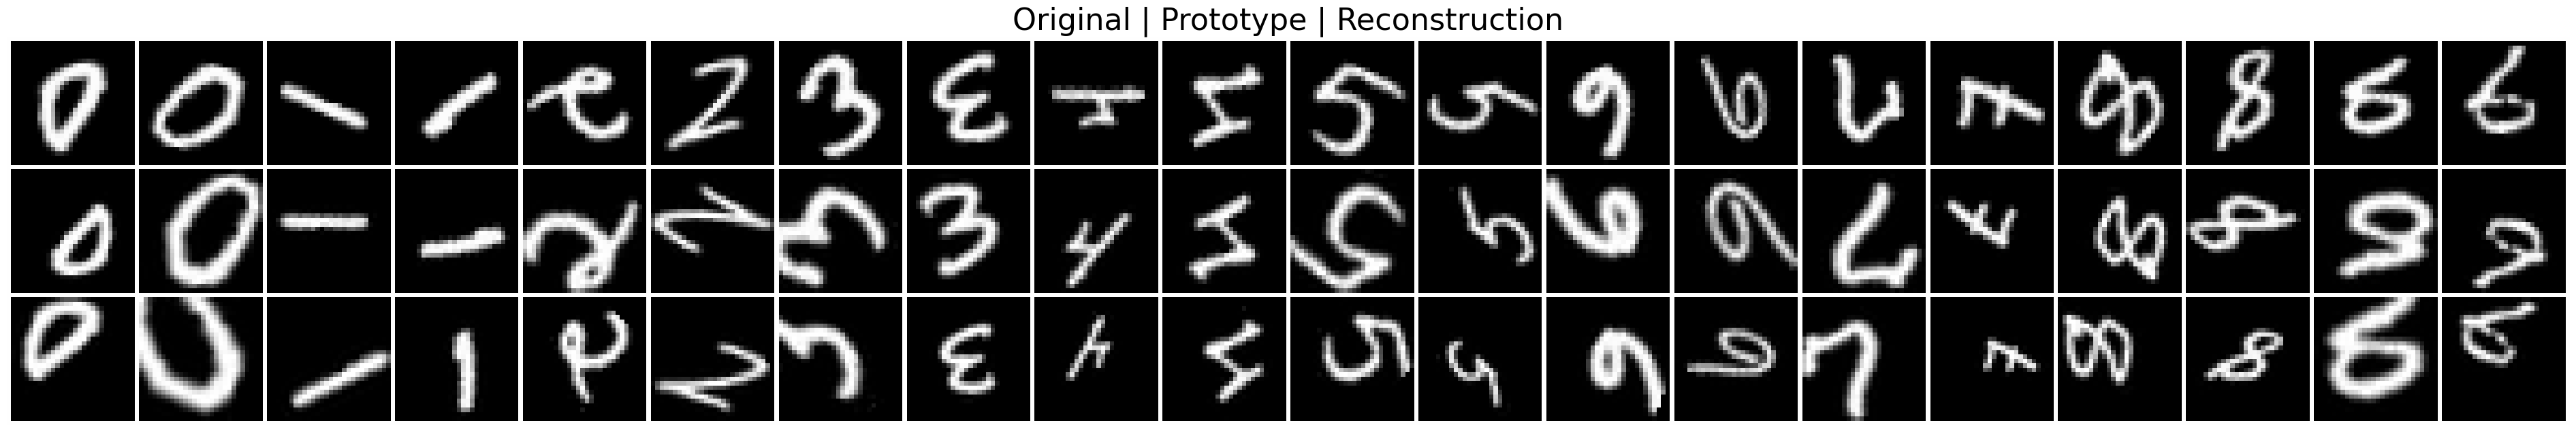

 10%|▉         | 497/5001 [01:36<04:57, 15.12it/s, Trn Loss 554.9,	 Trn LL -533.9,	 Val Loss 928.4,	 Val LL -925.8]  

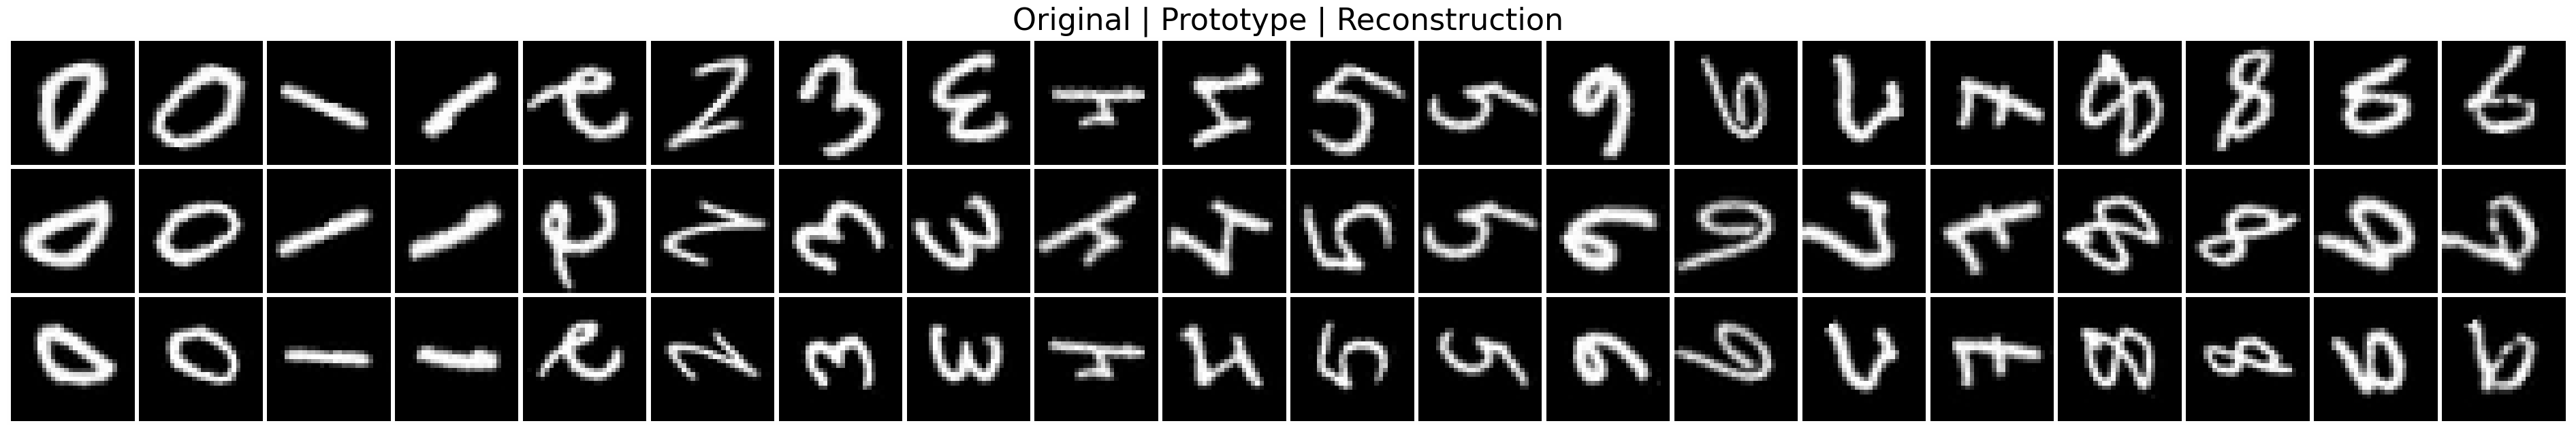

 20%|█▉        | 1000/5001 [01:57<02:42, 24.70it/s, Trn Loss 151.9,	 Trn LL -129.7,	 Val Loss 566.3,	 Val LL -544.2]

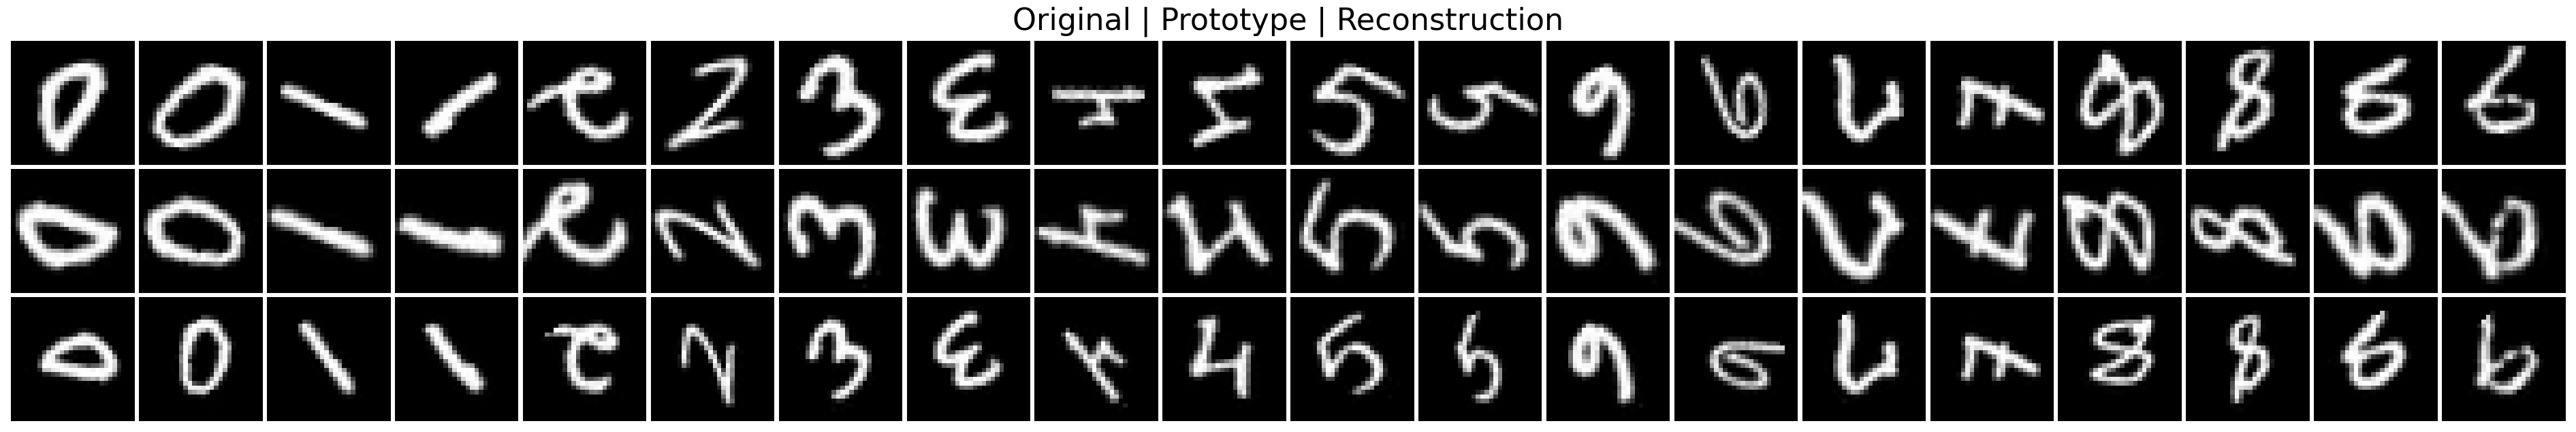

 30%|██▉       | 1500/5001 [02:17<01:55, 30.20it/s, Trn Loss 115.9,	 Trn LL -95.62,	 Val Loss 272.6,	 Val LL -246.1]

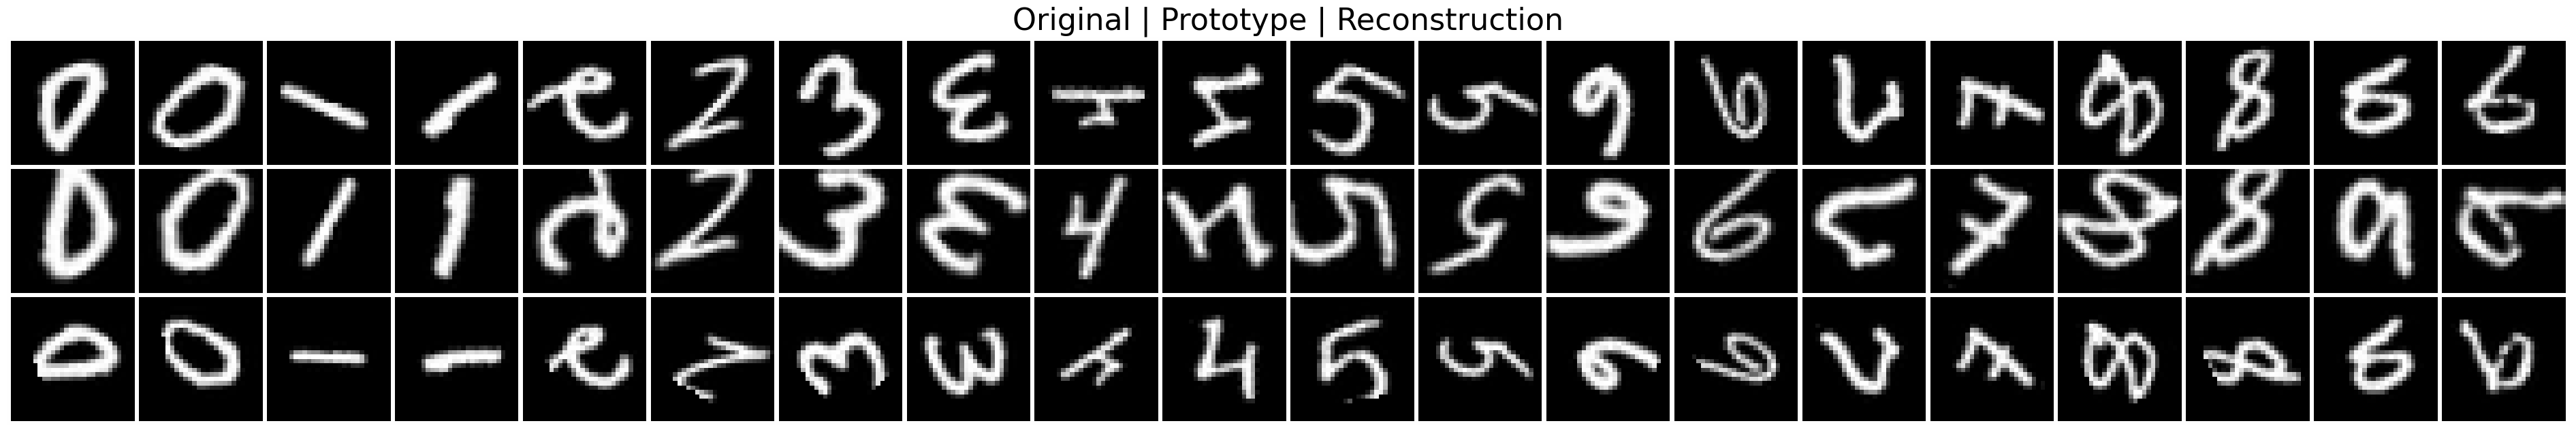

 40%|███▉      | 2000/5001 [02:38<01:28, 34.10it/s, Trn Loss 10.85,	 Trn LL 11.85,	 Val Loss 419.4,	 Val LL -398.2]  

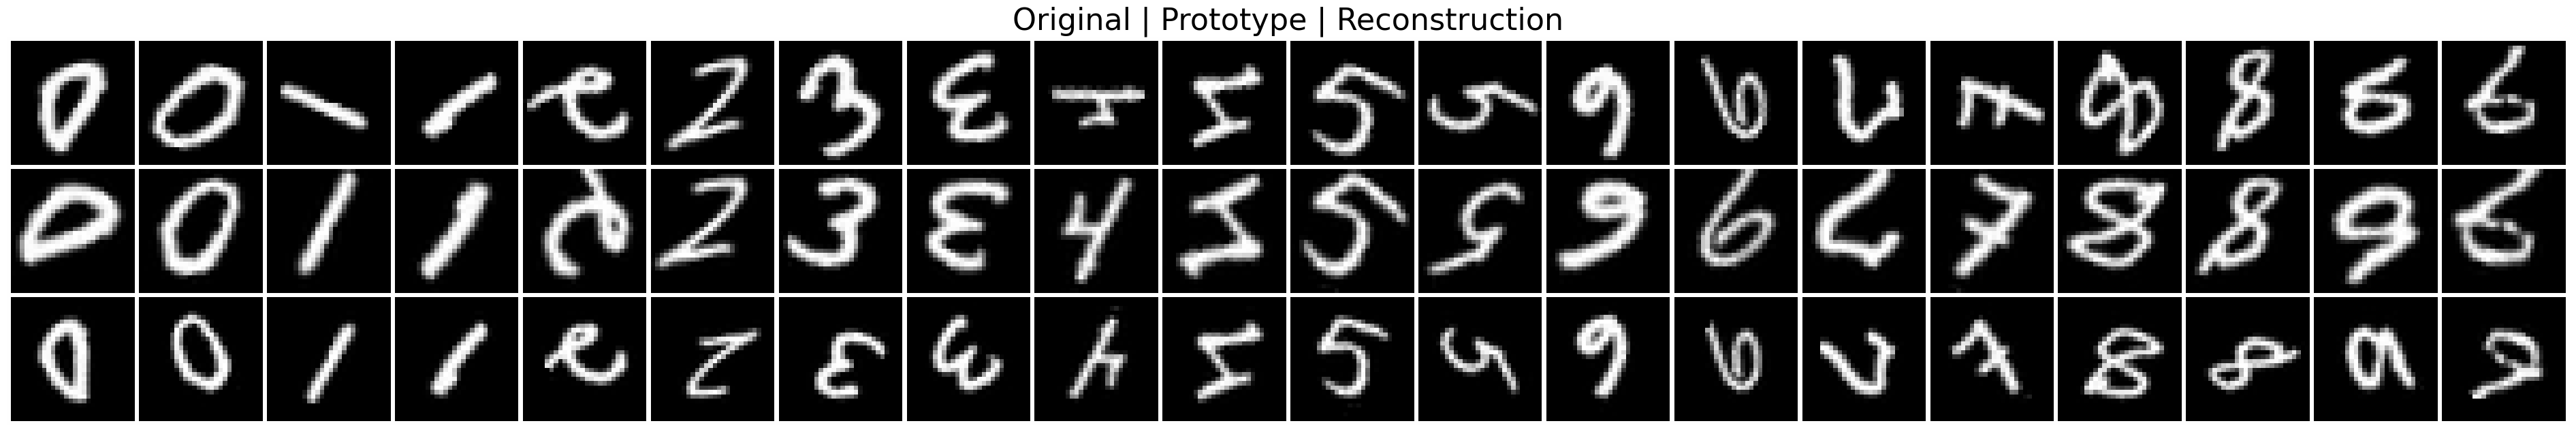

 50%|████▉     | 2500/5001 [02:58<01:10, 35.55it/s, Trn Loss 0.8419,	 Trn LL 22.54,	 Val Loss 398.3,	 Val LL -371.3]  

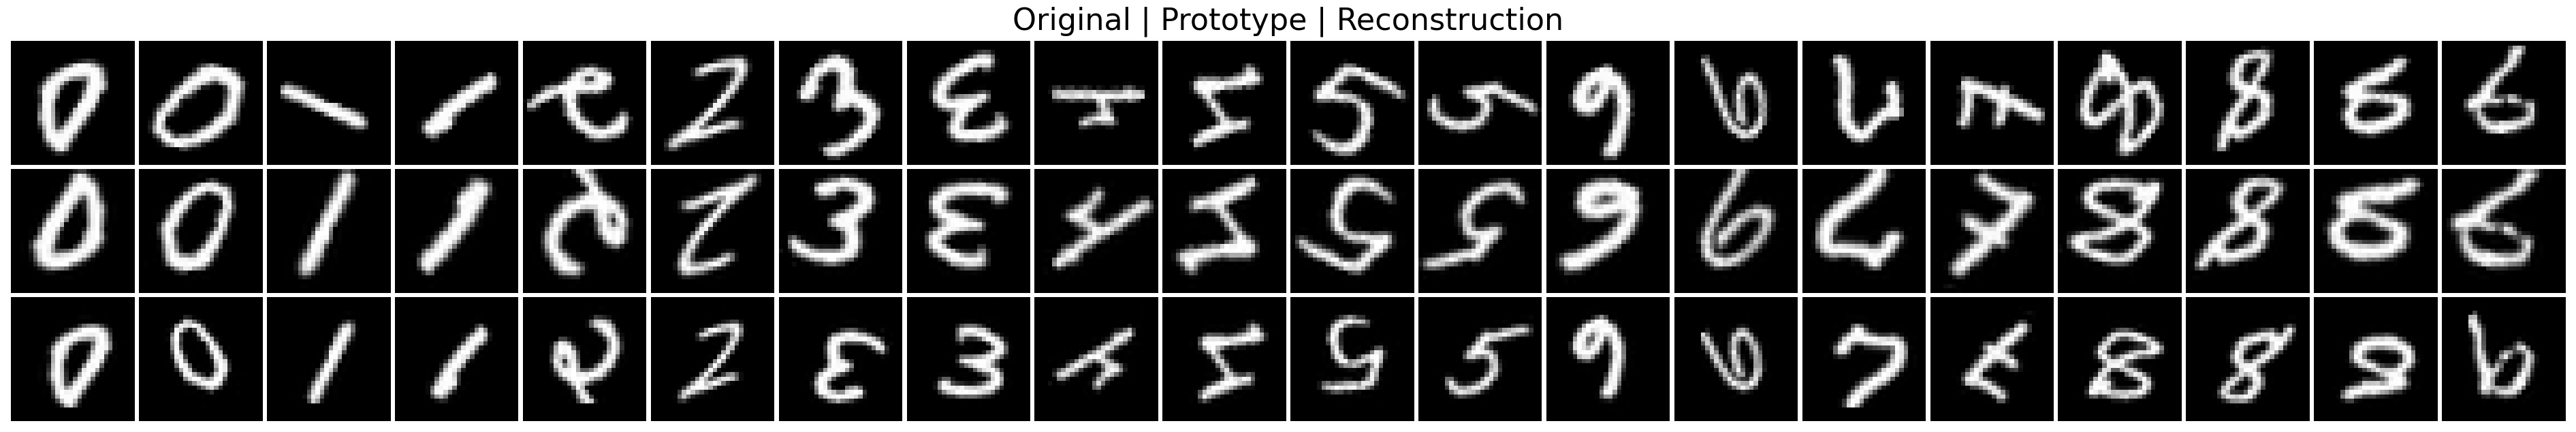

 60%|█████▉    | 3000/5001 [03:18<00:55, 36.30it/s, Trn Loss 12.16,	 Trn LL 9.416,	 Val Loss 490,	 Val LL -465.5]   

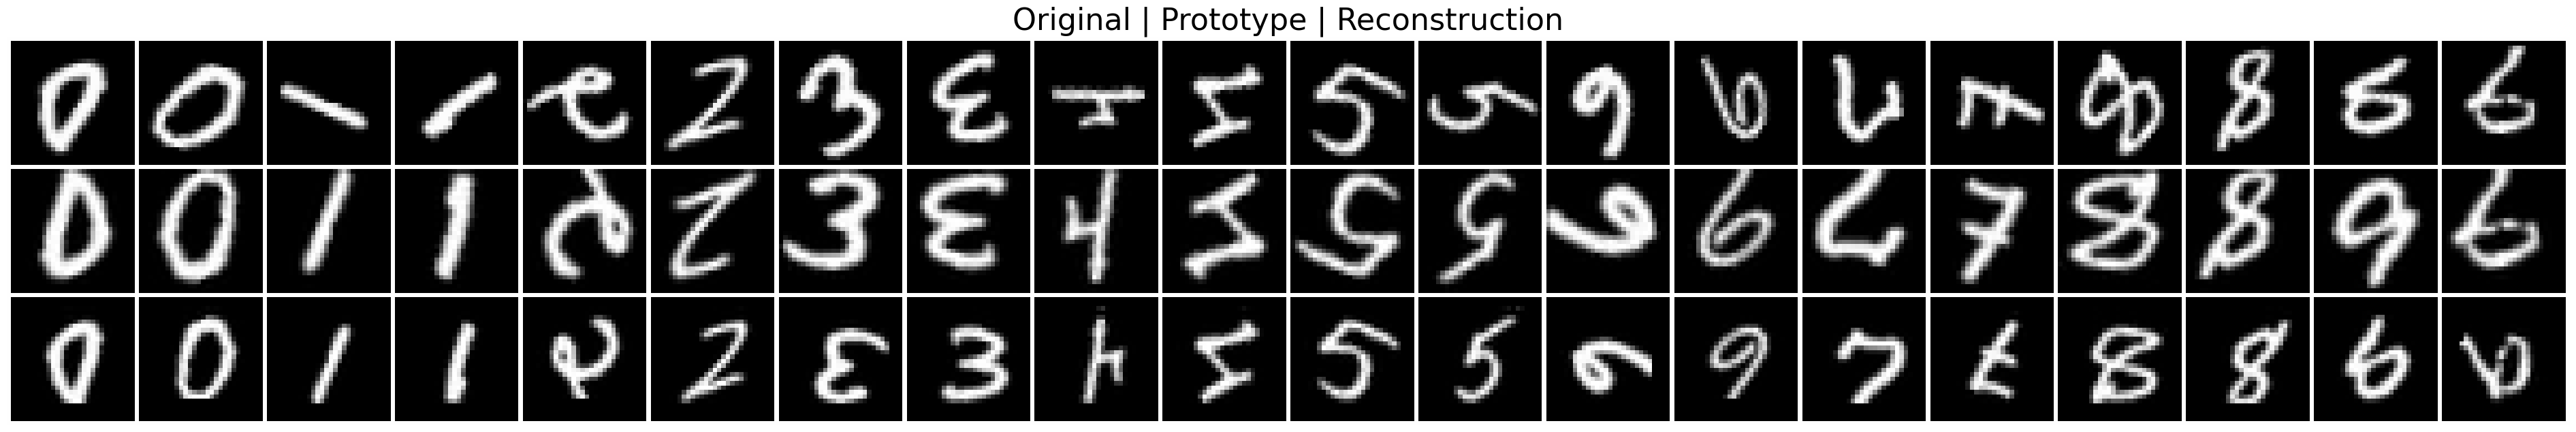

 70%|██████▉   | 3500/5001 [03:40<00:41, 35.85it/s, Trn Loss -1.85,	 Trn LL 23.75,	 Val Loss 440.4,	 Val LL -417.7]    

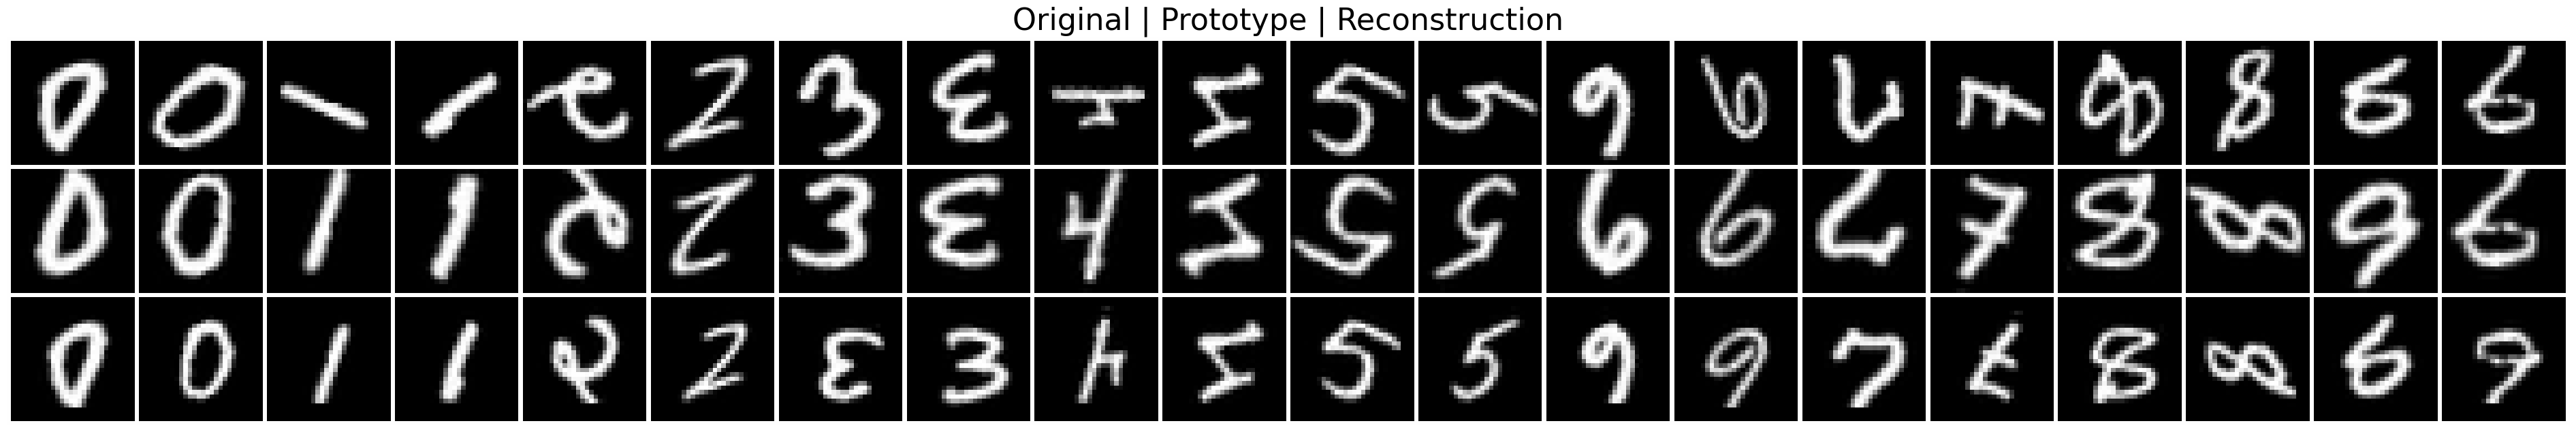

 80%|███████▉  | 3999/5001 [04:00<00:26, 37.28it/s, Trn Loss 13.89,	 Trn LL 8.771,	 Val Loss 265.4,	 Val LL -241.7]    

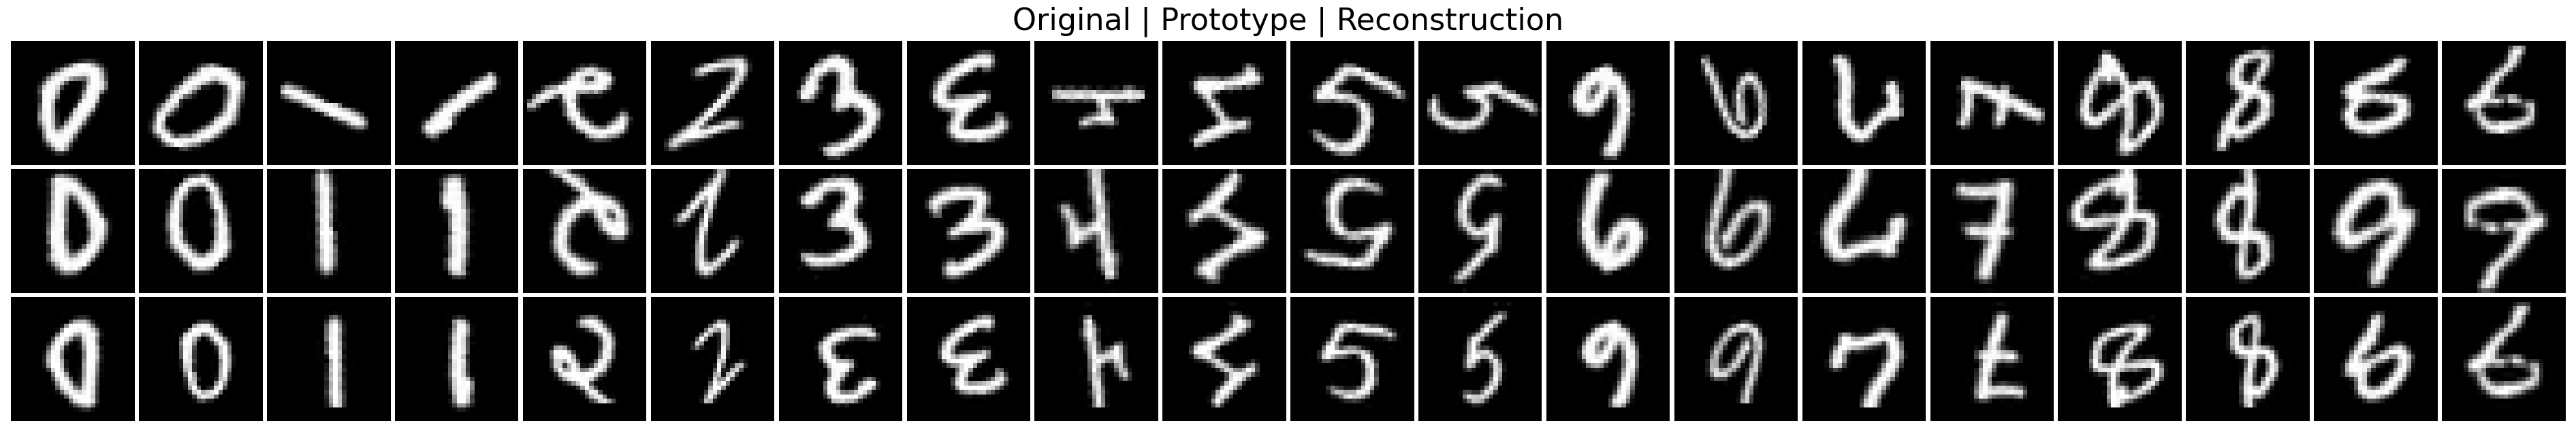

 90%|████████▉ | 4499/5001 [04:21<00:13, 36.08it/s, Trn Loss -32.89,	 Trn LL 55.91,	 Val Loss 130.6,	 Val LL -106.1]  

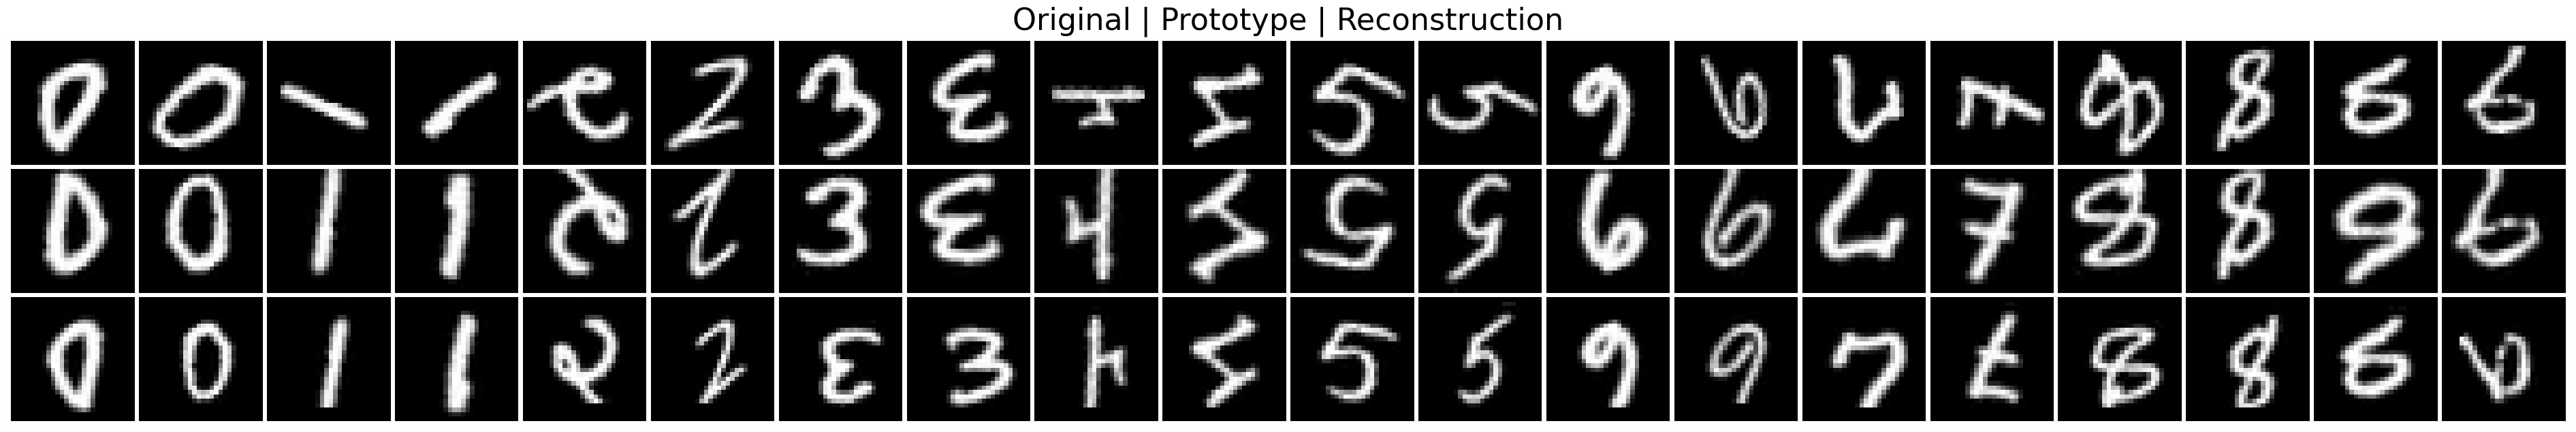

100%|█████████▉| 4998/5001 [04:43<00:00, 34.63it/s, Trn Loss -30.29,	 Trn LL 53.61,	 Val Loss 112.1,	 Val LL -87.6] 

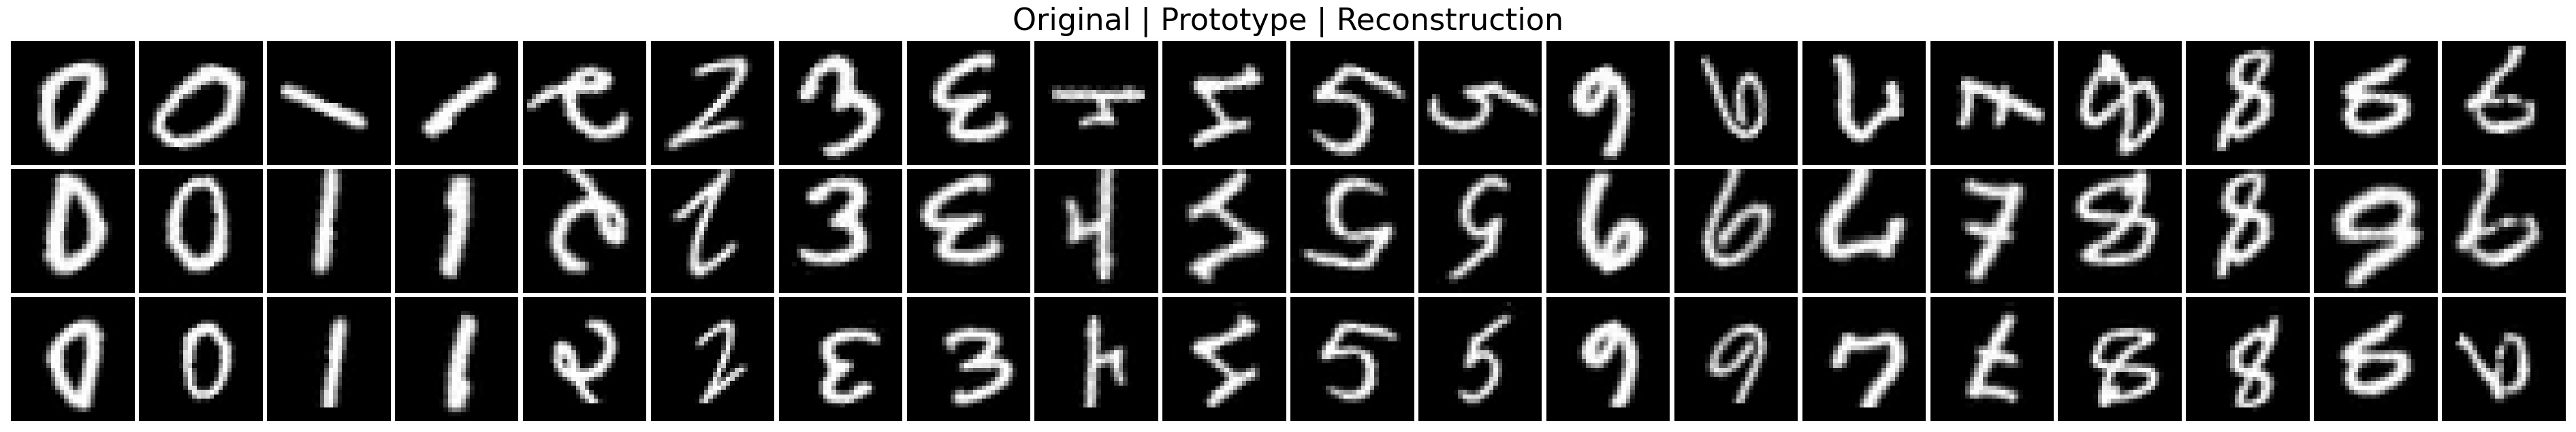

100%|██████████| 5001/5001 [04:46<00:00, 17.47it/s, Trn Loss -30.29,	 Trn LL 53.61,	 Val Loss 112.1,	 Val LL -87.6]
INFO:absl:Training finished.


(28, 28, 1)


/var/home/jua23/.virtualenvs/inv/lib/python3.9/site-packages/wandb/sdk/data_types/image.py:281: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  util.ensure_matplotlib_figure(data).savefig(buf)


(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


learing_rate,▂▃▅▆██████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
train/elbo,▁▁▂▃▃▄▅▆▆▇▇▇▇▇▇▇█▇▇████████▇██▇████▇████
train/ll,▁▁▂▃▃▄▅▆▆▇▇▇▇▇▇▇█▇▇████████▇██▇████▇████
train/ll_unorm,▁▁▂▃▃▄▅▆▆▇▇▇▇▇▇▇█▇▇████████▇██▇████▇████
train/loss,██▇▆▆▅▄▃▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▂▁▁▁▁
train/p_q_H_cent,██▆▆▇▆▆▅▄▆▅▁▄▄▁▂▅▁▄▅▅▄▅▅▅▄▄▃▄▅▄▅▅▅▆▅▆▅▅▅
train/p_η_ce,▃▃▃▄▄▆▅▄▃▆▃▁▇█▄▅▆▆▅▇▆▇█▇█▇▆█▇█▇▇▇▇▆▆▆▇▆▆
train/q_H_ent,█▆▄▄▃▃▂▃▃▂▂▂▃▂▂▂▂▁▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
train/q_η_ce,▆▇▄▆▅▇▆▅▃▅▃▁▇█▃▅▅▆▅▆▆▆▇▇▇▇▆▇▆▇▆▇▆▆▆▆▅▇▆▆
train/η_kld,▁▃▅▆▆▆▇▆▆▇▇▆▆▆▅▆▇▇▇▇█▇▇▇▇▇▇▇▆▇▇▇▇▇█▇▇▇▇▇
val/elbo,▁▄▇▅▅▅▅▇███


/var/home/jua23/.virtualenvs/inv/lib/python3.9/site-packages/IPython/core/events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/var/home/jua23/.virtualenvs/inv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


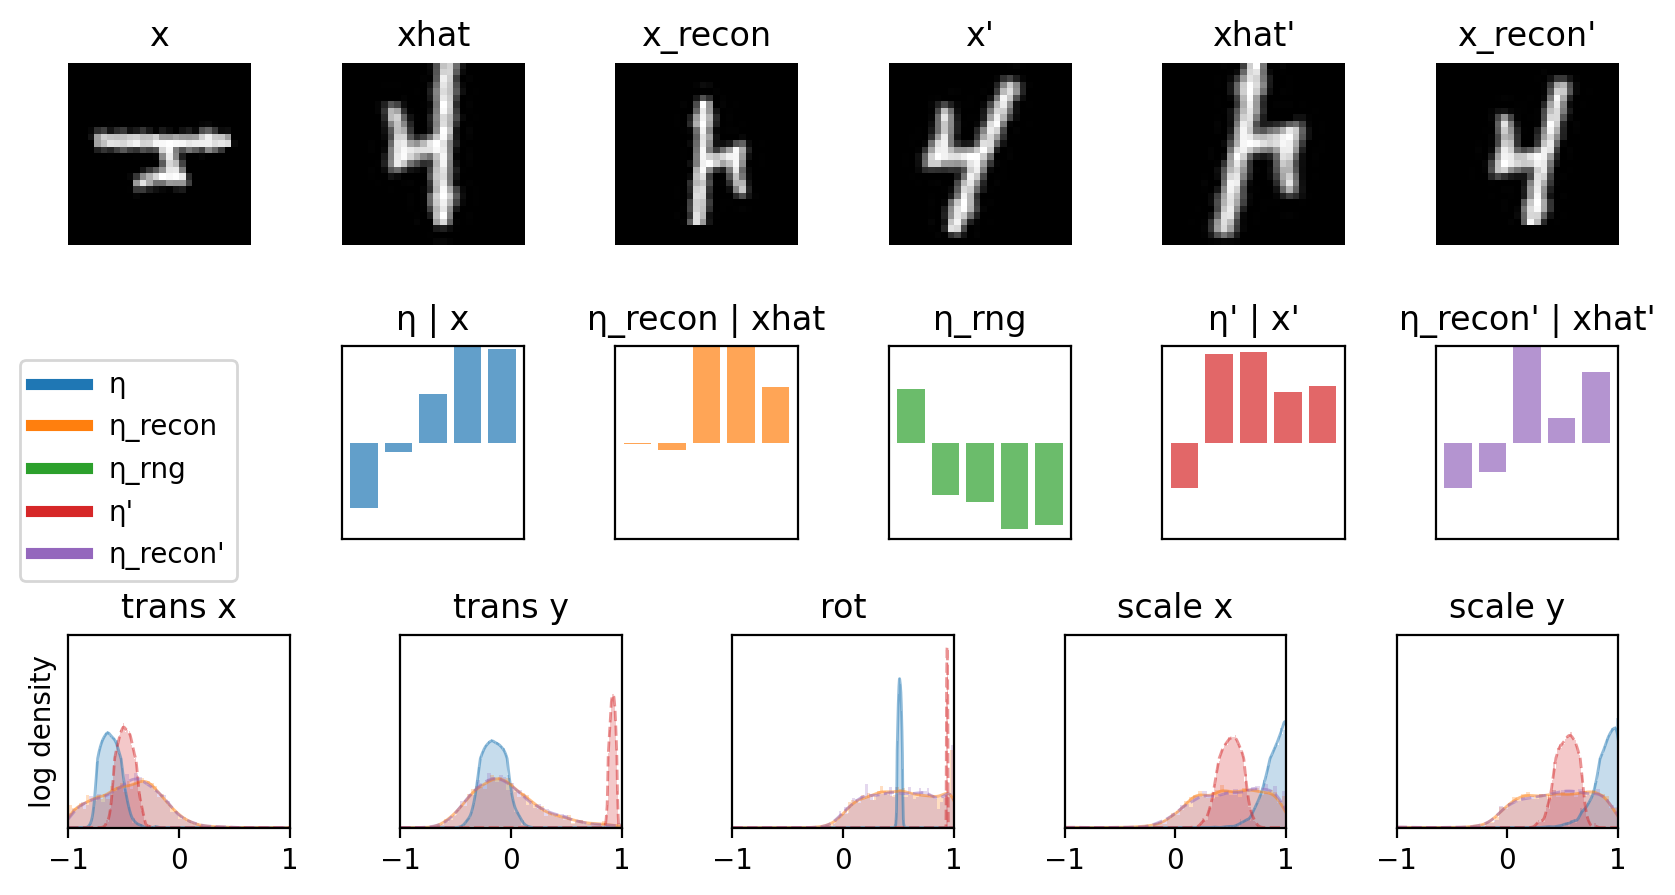

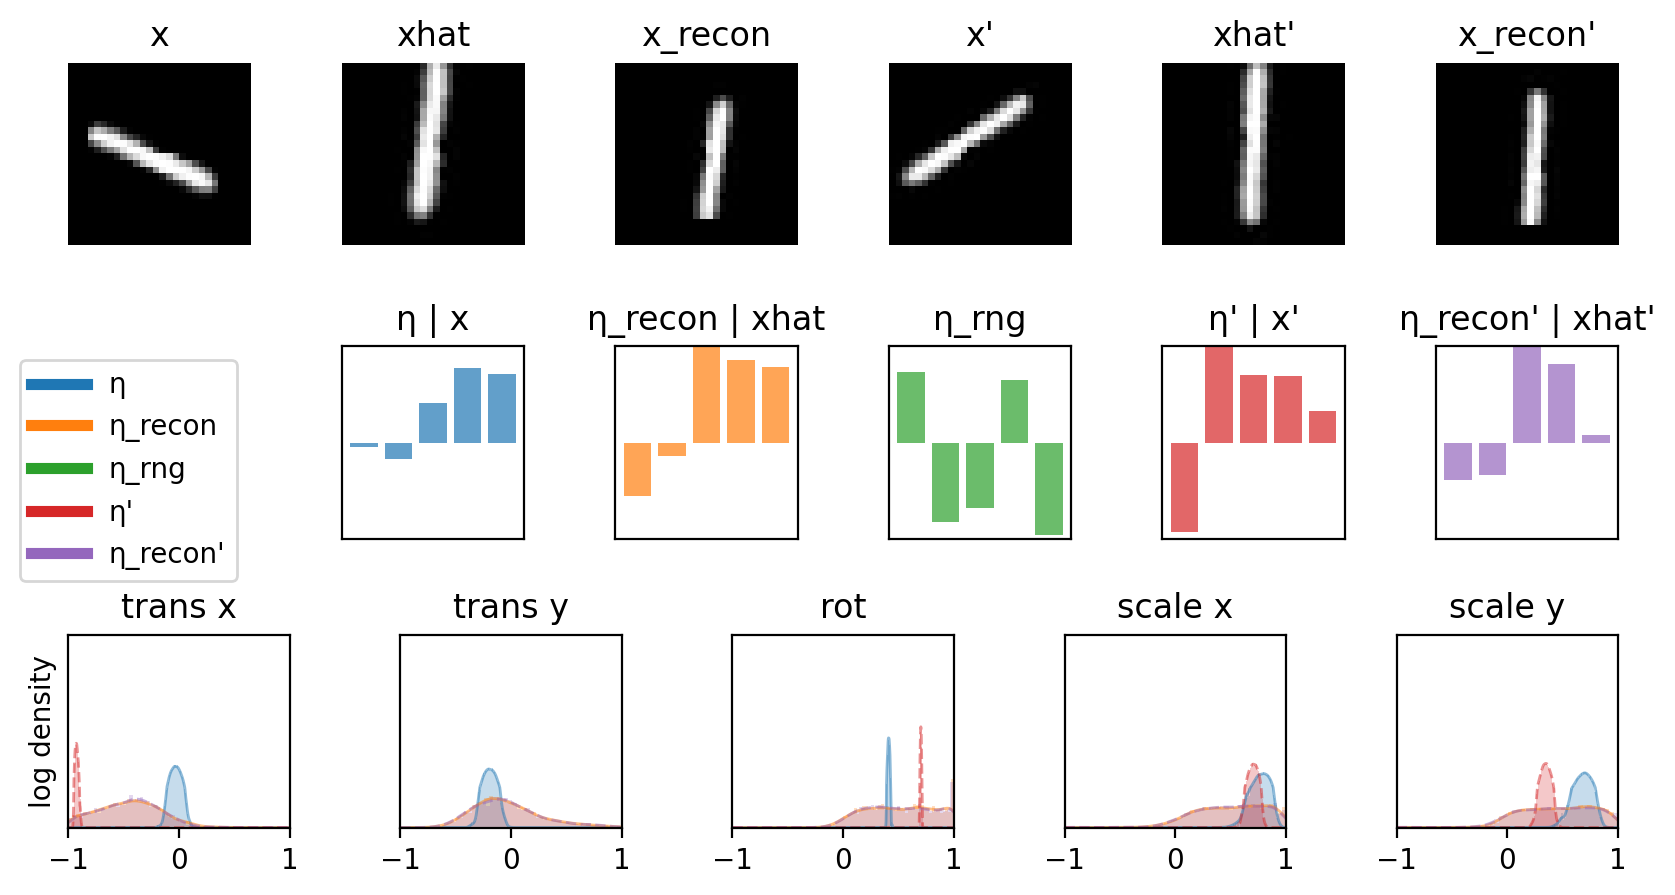

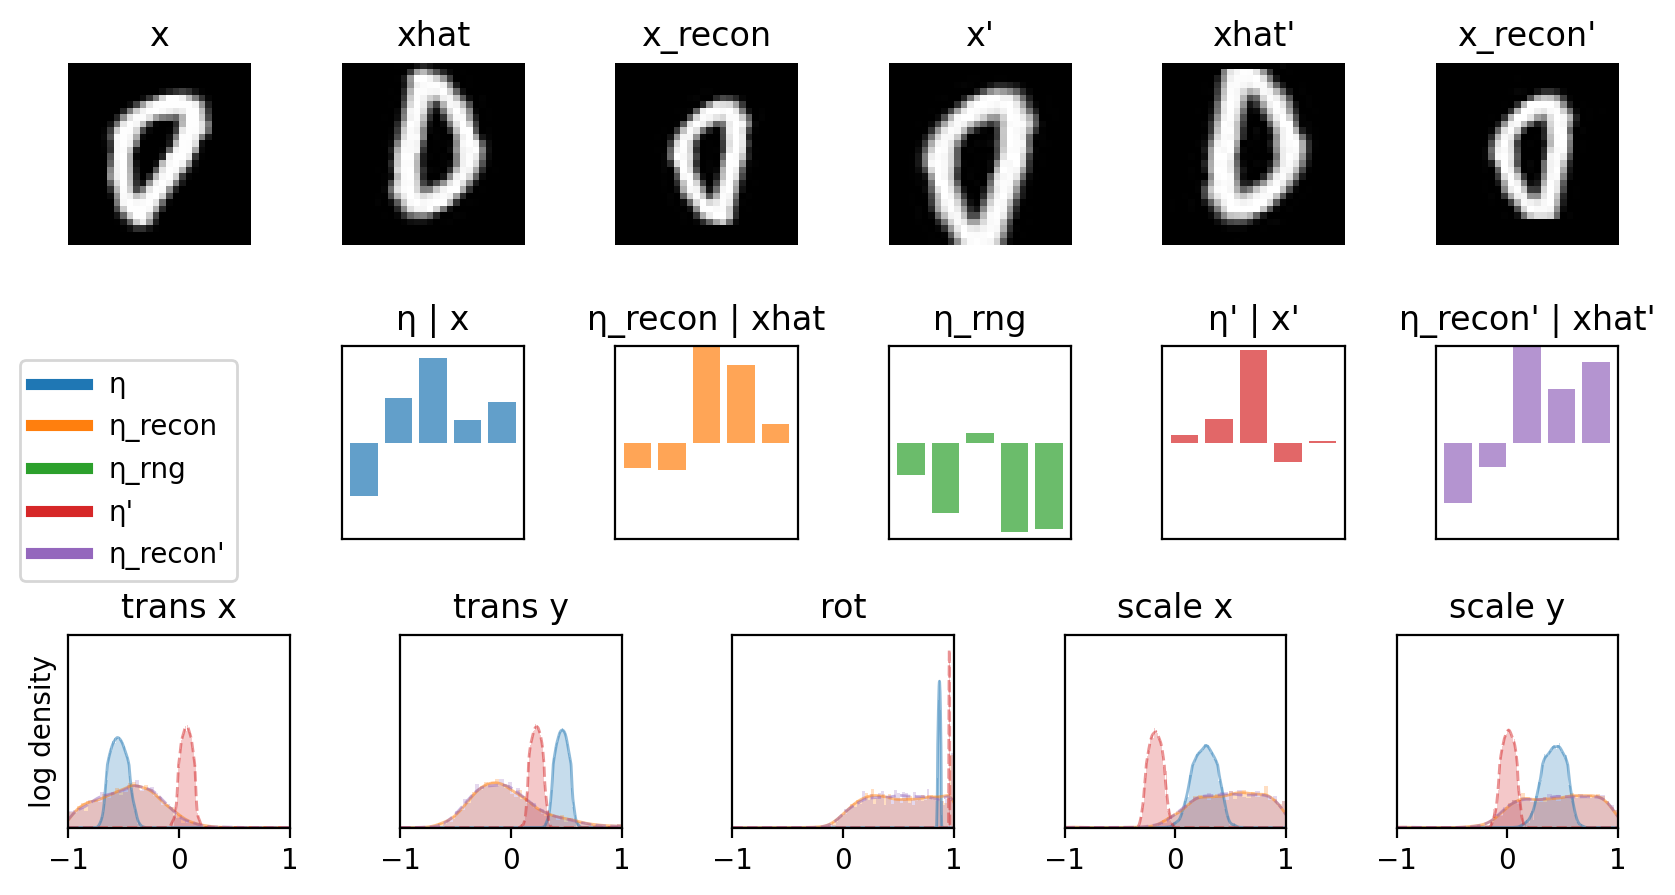

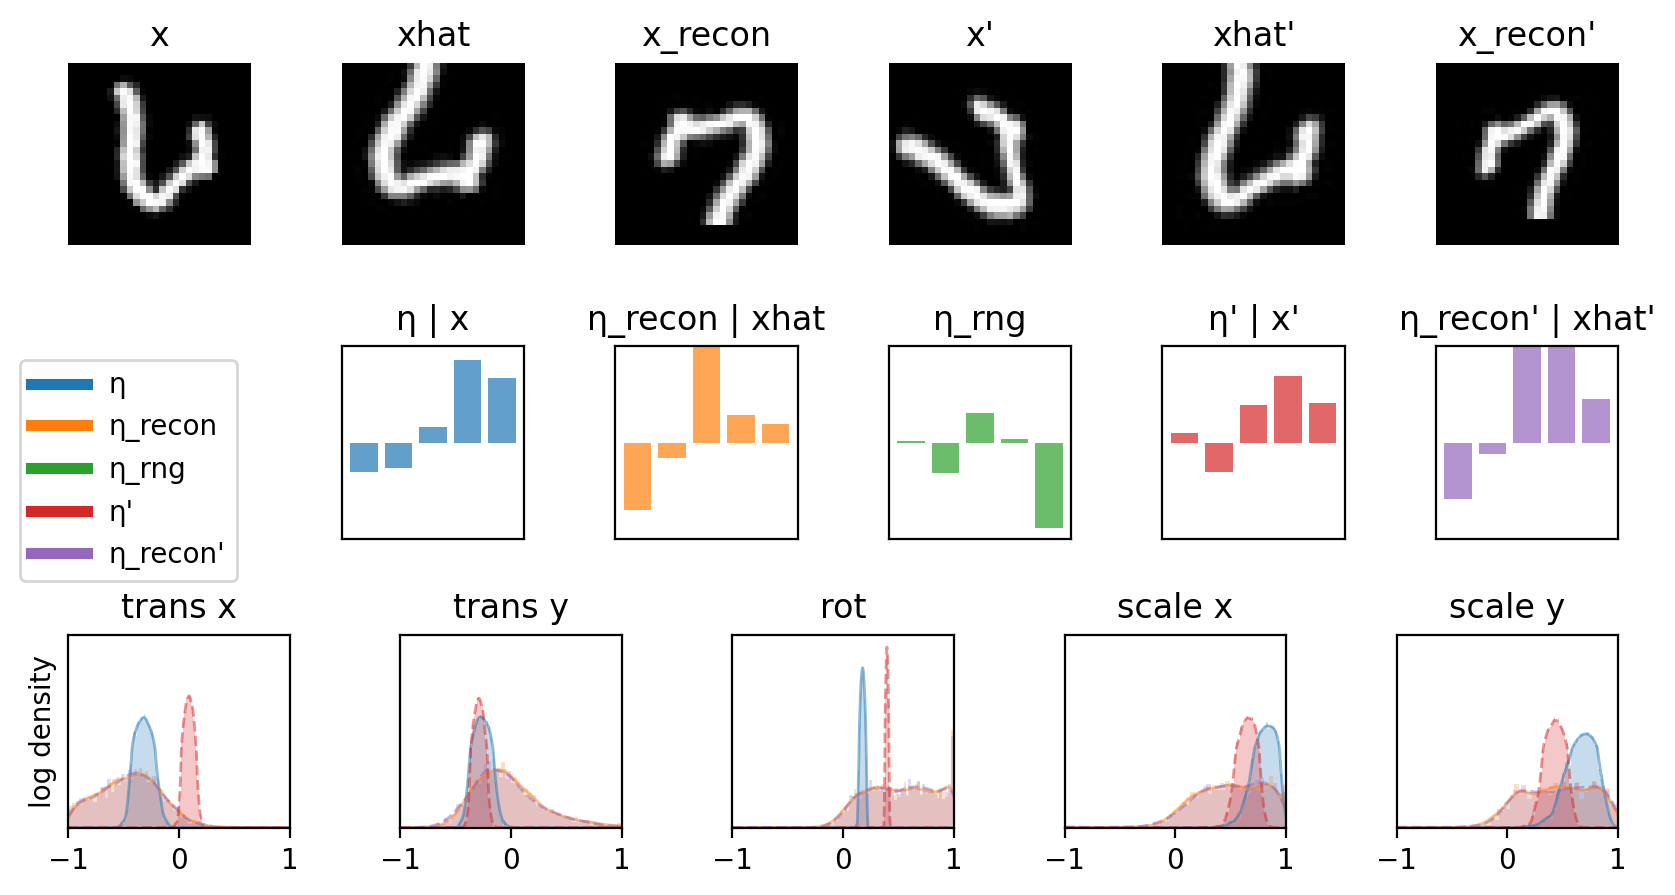

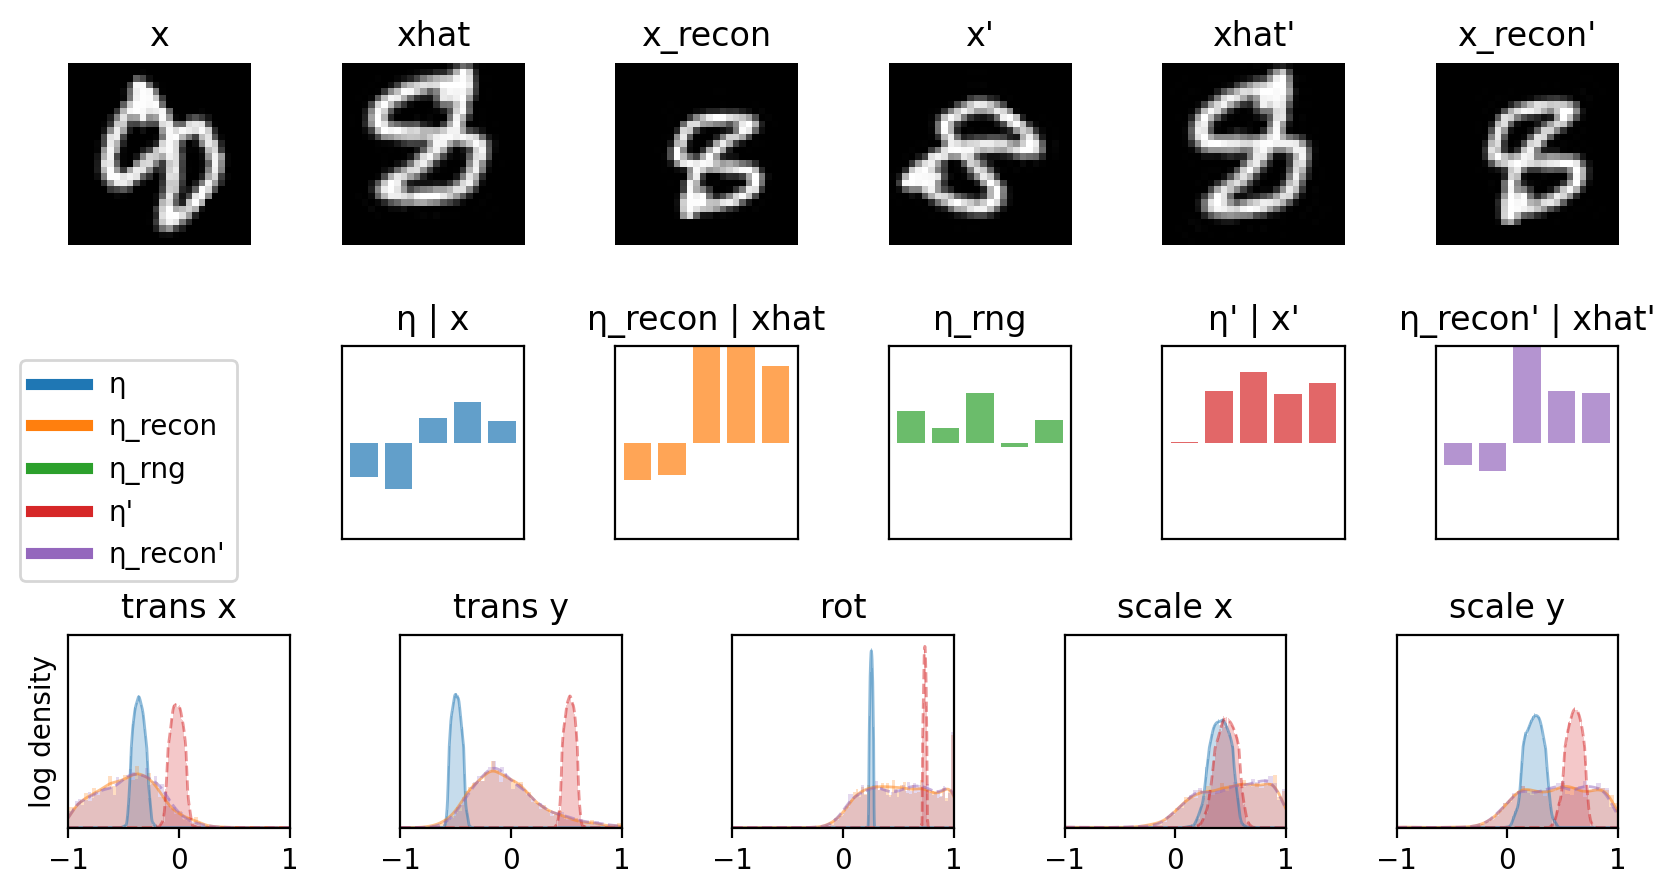

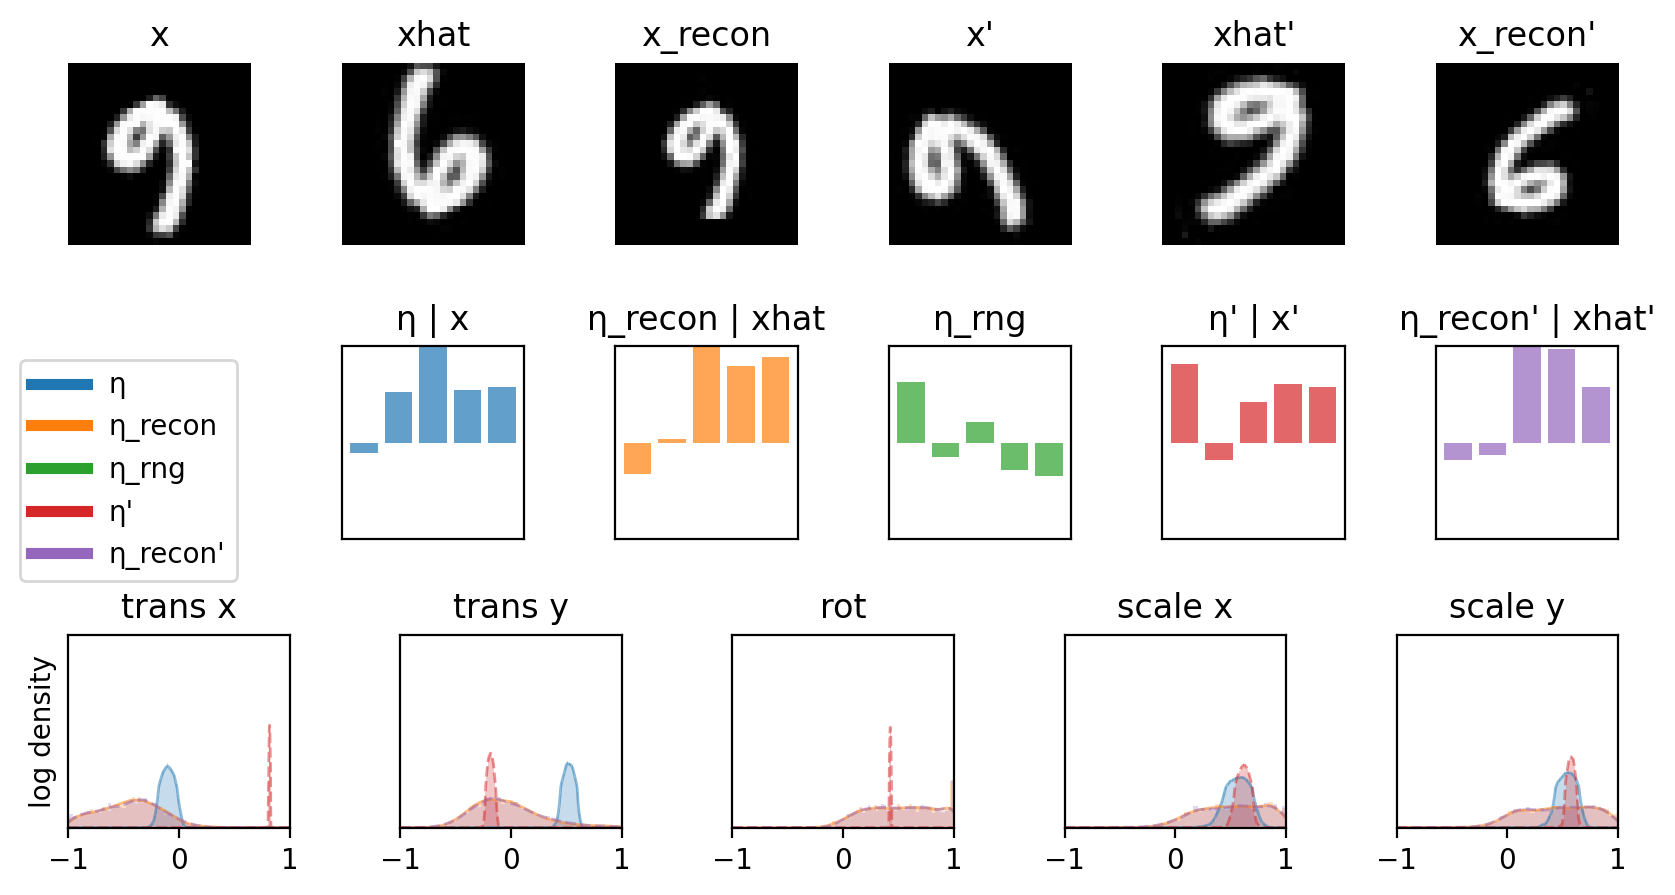

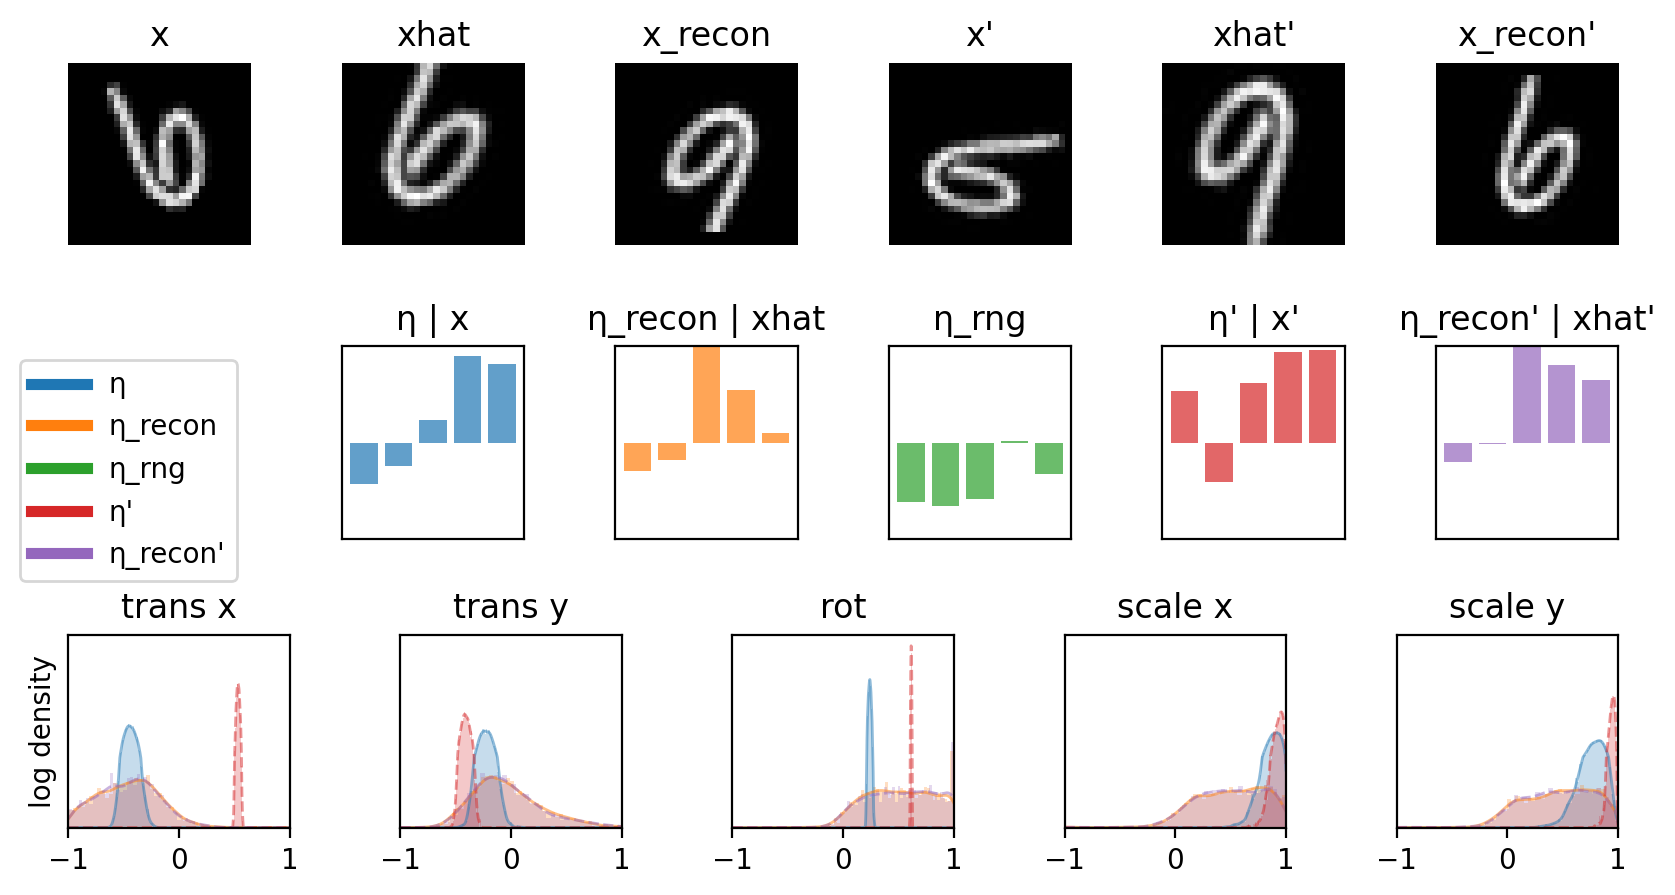

In [8]:
best_state, final_state = train_loop(
    config,
    model,
    state,
    train_ds,
    val_ds,
    wandb_kwargs={
        'mode': 'online',
        'tags': ['tuning', 'mnist', 'ssil'], 
        'notes': (
            'Tuning SSIL on MNIST with full rotations. '
            'γ = 1 -> 0. In 1/4 the steps. '
            # 'Sample larger η more often, as we train for longer. Delayed start to schedule.'
            # 'Slightly bigger trunk, still no conv. '
            # 'Remove resize. '
        )
    }
);


In [9]:
val_iter = input_utils.start_input_pipeline(val_ds, config.get("prefetch_to_device", 1))
val_batch = next(val_iter)

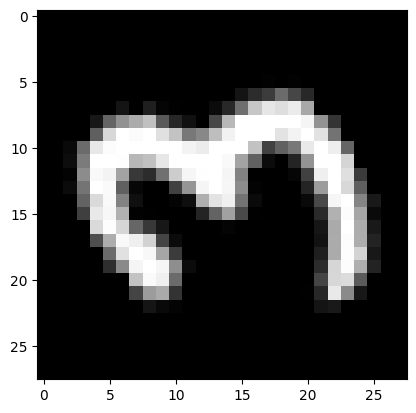

In [10]:
x = val_batch['image'][0][14]

plt.imshow(x, cmap='gray')

In [11]:
from src.models.common import (
    Flow,
    INV_SOFTPLUS_1,
    approximate_mode,
)
from src.utils import input as input_utils
from src.transformations import transform_image
import src.utils.plotting as plotting_utils

import jax
import distrax

rotated_xs = [transform_image(x, jnp.array([0., 0., angle * jnp.pi / 180, 0., 0.])) for angle in jnp.arange(0., 361, 30)]

η_rng, η_p_rng, η_pp_rng, η_recon_p_rng, η_recon_rng = random.split(rng, 5)

bounds_array = jnp.array(config.model.bounds)
offset_array = jnp.array(config.model.offset)

q_Η_given_X = Flow(
    **(config.model.Η_given_X or {}),
    event_shape=(5,),
    bounds_array=bounds_array,
    offset_array=offset_array,
)

def get_proto(x):
    q_Η_given_x = q_Η_given_X.apply({"params": final_state.params["q_Η_given_X"]}, x, train=False)

    η1 = approximate_mode(q_Η_given_x, 100, rng=η_rng)

    xhat = transform_image(x, -η1)

    return xhat

xhats = [get_proto(x) for x in rotated_xs]

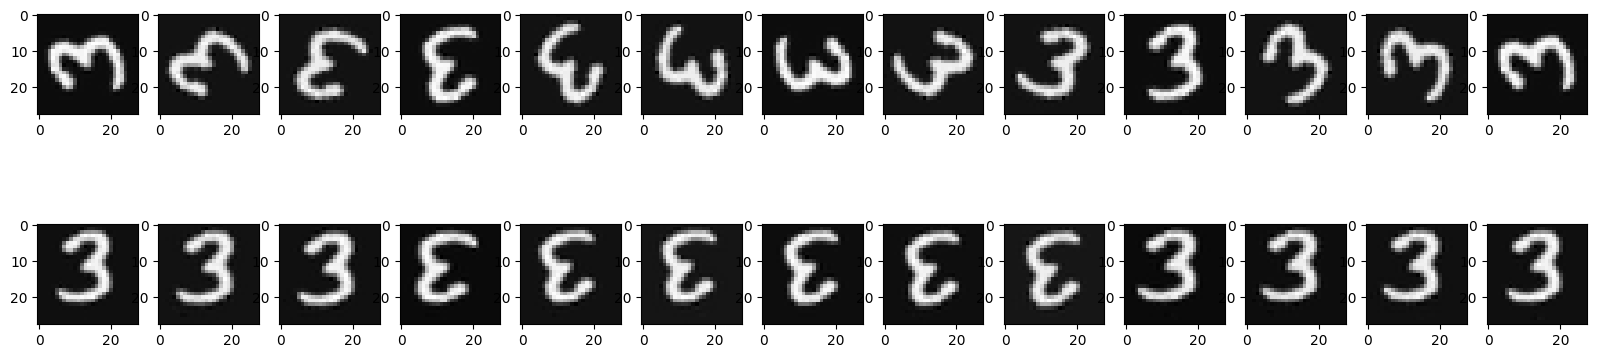

In [12]:
fig, axs = plt.subplots(2, len(xhats), figsize=(20, 5))

for ax, x in zip(axs[0], rotated_xs):
    ax.imshow(x, cmap='gray')

for ax, xhat in zip(axs[1], xhats):
    ax.imshow(xhat, cmap='gray')

plt.show()

TODO prior exps:
1. Try make prior ~~invariant, by feeding in x_uniform.~~ equivariant?
2. Compare learning prior jointly or just after. 

In [13]:
if RUN_EXTRA:
    pass
else:
    raise RuntimeError("Set RUN_EXTRA to True to keep running NB.")

RuntimeError: Set RUN_EXTRA to True to keep running NB.

## Color Tests

In [ ]:
plt.imshow(plotting_utils.rescale_for_imshow(transform_image(xs[0, 2], jnp.array([.1, .1, jnp.pi/2, .1, .1, .5]))))

In [ ]:
from src.models.common import (
    Flow,
    INV_SOFTPLUS_1,
    approximate_mode,
)
from src.utils import input as input_utils
from src.transformations import transform_image
import src.utils.plotting as plotting_utils

import jax
import distrax


In [ ]:
η_rng, η_p_rng, η_pp_rng, η_recon_p_rng, η_recon_rng = random.split(rng, 5)

bounds_array = jnp.array(config.model.bounds)
offset_array = jnp.array(config.model.offset)

q_Η_given_X = Flow(
    **(config.model.Η_given_X or {}),
    event_shape=(7,),
    bounds_array=bounds_array,
    offset_array=offset_array,
)
p_Η_given_Xhat = Flow(
    **(config.model.Η_given_Xhat or {}),
    event_shape=(7,),
    bounds_array=bounds_array,
    offset_array=offset_array,
)

AttributeError: "'bounds'"

In [ ]:
val_iter = input_utils.start_input_pipeline(val_ds, config.get("prefetch_to_device", 1))
val_batch = next(val_iter)
x = val_batch['image'][0][4]

In [ ]:
q_Η_given_x = q_Η_given_X.apply({"params": final_state.params["q_Η_given_X"]}, x, train=False)

# η1 = approximate_mode(q_Η_given_x, 100, rng=η_rng)
η1 = q_Η_given_x.sample(seed=η_rng)
η1

ScopeParamShapeError: Inconsistent shapes between value and initializer for parameter "kernel" in "/cond_0/final": (128, 96), (128, 112). (https://flax.readthedocs.io/en/latest/flax.errors.html#flax.errors.ScopeParamShapeError)

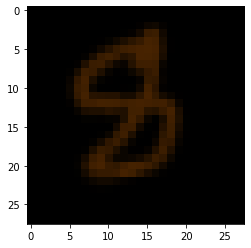

In [ ]:
xhat = transform_image(x, -η1)
plt.imshow(plotting_utils.rescale_for_imshow(xhat))

In [ ]:
p_Η_given_xhat = p_Η_given_Xhat.apply({"params": state.params["p_Η_given_Xhat"]}, x, train=False)

η2 = approximate_mode(p_Η_given_xhat, 100, rng=η_p_rng)
η2

DeviceArray([ 0.23328158,  0.14378054, -2.5265348 , -0.23094448,
              0.08132553,  0.4357713 ,  0.9801643 ], dtype=float32)

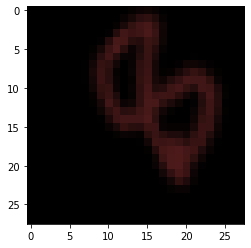

In [ ]:
xrecon = transform_image(xhat, η2)
plt.imshow(plotting_utils.rescale_for_imshow(xrecon))

In [ ]:
bounds = jnp.array(config.model.bounds)
offset = jnp.array(config.model.offset)

In [ ]:
η_rng, η_unif_rng, η_tot_rng = random.split(rng, 3)

Η_uniform = distrax.Uniform(
    low=-bounds + offset,
    high=bounds + offset,
)
η_uniform = Η_uniform.sample(seed=η_unif_rng)
η_uniform

DeviceArray([-0.22365803,  0.20020235, -2.3386316 , -0.15589088,
             -0.03869641,  0.43836045,  0.3555907 ], dtype=float32)

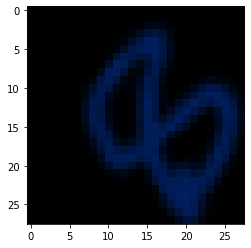

In [ ]:
x_uniform = transform_image(x, η_uniform)
plt.imshow(plotting_utils.rescale_for_imshow(x_uniform))

In [ ]:
q_Η_given_x_uniform = q_Η_given_X.apply({"params": state.params["q_Η_given_X"]}, x_uniform, train=True)
η_tot = q_Η_given_x_uniform.sample(seed=η_tot_rng)
η_tot

DeviceArray([-0.09184143, -0.22492959,  1.5648651 , -0.0368023 ,
              0.20159243,  0.07989672,  0.254591  ], dtype=float32)

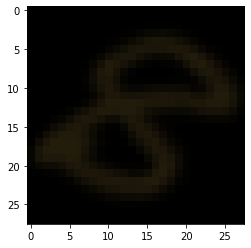

In [ ]:
xhat = transform_image(x_uniform, -η_tot)
plt.imshow(plotting_utils.rescale_for_imshow(xhat))

In [ ]:
p_Η_given_xhat = p_Η_given_Xhat.apply({"params": state.params["p_Η_given_Xhat"]}, xhat, train=True)
η_ = p_Η_given_xhat.sample(seed=η_rng)
η_

DeviceArray([-0.20699307,  0.15301141,  2.2930272 ,  0.20846437,
              0.15295033, -0.25107166,  0.30715185], dtype=float32)

In [ ]:
q_Η_given_x = q_Η_given_X.apply({"params": state.params["q_Η_given_X"]}, x, train=True)
η = q_Η_given_x.sample(seed=η_rng)
η

DeviceArray([-0.20699307,  0.15301141,  2.2930272 ,  0.20846437,
              0.15295033, -0.25107166,  0.30715185], dtype=float32)

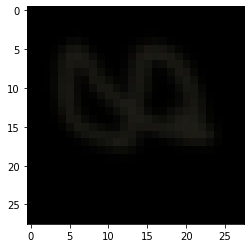

In [ ]:
xrecon = transform_image(xhat, η)
plt.imshow(plotting_utils.rescale_for_imshow(xrecon))

In [ ]:
p_X_given_xhat_and_η = distrax.Independent(
    distrax.Normal(xrecon, jax.nn.softplus(state.params['σ_']).clip(min=1e-2)), reinterpreted_batch_ndims=len(x.shape)
)

In [ ]:
bounds = jnp.array(config.model.bounds)
offset = jnp.array(config.model.offset)

η_rng, η_unif_rng, η_tot_rng = random.split(rng, 3)

Η_uniform = distrax.Uniform(
    low=-bounds + offset,
    high=bounds + offset,
)
η_uniform = Η_uniform.sample(seed=η_unif_rng)

x_uniform = transform_image(x, η_uniform)

q_Η_given_x_uniform = q_Η_given_X.apply({"params": state.params["q_Η_given_X"]}, x_uniform, train=True)
η_tot = q_Η_given_x_uniform.sample(seed=η_tot_rng)
η_tot

DeviceArray([-0.09184143, -0.22492959,  1.5648651 , -0.0368023 ,
              0.20159243,  0.07989672,  0.254591  ], dtype=float32)

In [ ]:
q_Η_given_x_uniform.sample(seed=η_tot_rng)

DeviceArray([-0.09184143, -0.22492959,  1.5648651 , -0.0368023 ,
              0.20159243,  0.07989672,  0.254591  ], dtype=float32)

In [ ]:
def loss_fn(params, rng, x):
    bounds = jnp.array(config.model.bounds)
    offset = jnp.array(config.model.offset)

    η_rng, η_unif_rng, η_tot_rng = random.split(rng, 3)

    Η_uniform = distrax.Uniform(
        low=-bounds + offset,
        high=bounds + offset,
    )
    η_uniform = Η_uniform.sample(seed=η_unif_rng)

    x_uniform = transform_image(x, η_uniform)
    
    q_Η_given_x_uniform = q_Η_given_X.apply({"params": params["q_Η_given_X"]}, x_uniform, train=True)
    η_tot = q_Η_given_x_uniform.sample(seed=η_tot_rng)

    xhat = transform_image(x_uniform, -η_tot)
    
    p_Η_given_xhat = p_Η_given_Xhat.apply({"params": params["p_Η_given_Xhat"]}, xhat, train=True)
    η_ = p_Η_given_xhat.sample(seed=η_rng)

    q_Η_given_x = q_Η_given_X.apply({"params": params["q_Η_given_X"]}, x, train=True)
    η = q_Η_given_x.sample(seed=η_rng)

    xrecon = transform_image(xhat, η)

    p_X_given_xhat_and_η = distrax.Independent(
        distrax.Normal(xrecon, jax.nn.softplus(params['σ_']).clip(min=1e-2)), reinterpreted_batch_ndims=len(x.shape)
    )
    n = 100
    ε: float = 1e-6
    β = 1
    γ = 1

    rng1, rng2 = random.split(rng, 2)

    ll = p_X_given_xhat_and_η.log_prob(x)
    # normalise ll by the number of channels
    # TODO: maybe we should normalise by the number of pixels instead?
    ll = ll / x.shape[-1]

    η_qs, q_Η_log_probs = q_Η_given_x.sample_and_log_prob(seed=rng1, sample_shape=(n,))
    q_H_entropy = -jnp.mean(q_Η_log_probs, axis=0)

    p_Η_log_probs = jax.vmap(p_Η_given_xhat.log_prob)(
        η_qs.clip(min=(1 - ε) * (-bounds) + offset, max=(1 - ε) * (bounds) + offset)
    )
    p_q_H_cross_entropy = -jnp.mean(p_Η_log_probs, axis=0)

    η_kld_ = p_q_H_cross_entropy - q_H_entropy

    def norm(η) -> float:
        return jnp.sum(η**2) / len(η)

    q_η_norm = jax.vmap(norm)(η_qs).mean()

    η_ps = p_Η_given_xhat.sample(seed=rng2, sample_shape=(n,))
    p_η_norm = jax.vmap(norm)(η_ps).mean()

    η_kld = η_kld_ + γ * (q_η_norm + p_η_norm)

    elbo = ll - β * η_kld + q_H_entropy

    return -elbo, {
        "elbo": elbo,
        "ll": ll,
        "η_kld": η_kld,
        "η_kld_": η_kld_,
        "q_η_ce": q_η_norm,
        "p_η_ce": p_η_norm,
        "entropy_term": q_H_entropy,
    }

grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
(loss, metrics), grad = grad_fn(state.params, rng, x)

print(loss)
print(metrics)

795.67175
{'elbo': DeviceArray(-795.67175, dtype=float32), 'entropy_term': DeviceArray(-1.1057593, dtype=float32), 'll': DeviceArray(-793.2932, dtype=float32), 'p_η_ce': DeviceArray(0.6800186, dtype=float32), 'q_η_ce': DeviceArray(0.59273, dtype=float32), 'η_kld': DeviceArray(1.2727481, dtype=float32), 'η_kld_': DeviceArray(-4.7683716e-07, dtype=float32)}


In [ ]:
# calculate new params using jax tree map
new_params = jax.tree_map(lambda p, g: p - 1e-36 * g, state.params, grad)

In [ ]:
loss_fn(new_params, rng, x)

AssertionError: [Chex] Assertion assert_shape failed: Error in shape compatibility check: input 0 has shape (7,) but expected (6).

In [ ]:
q_Η_given_x_uniform = q_Η_given_X.apply({"params": new_params["q_Η_given_X"]}, x_uniform, train=True)
η_tot = q_Η_given_x_uniform.sample(seed=η_tot_rng)
η_tot

DeviceArray([-0.09184143, -0.22492959,  1.5648651 , -0.0368023 ,
              0.20159243,  0.07989672,  0.254591  ], dtype=float32)

In [ ]:
from src.transformations.color import color_transform_image, hsv_transform_image

η: [0.         0.10033467]
(r, g, b): [-1.        -1.        -0.6163977]


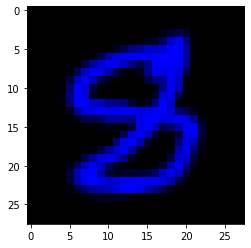

η: [-0.02250596 -0.24104635]
g: [0.02250216 0.3365341 ]
v: -0.9223950505256653
(r, g, b): [-0.960628   -0.960628   -0.92239505]


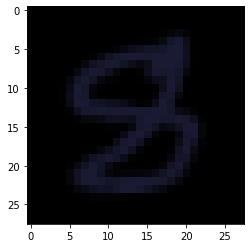

η: [ 1.1462864 -1.2562872]
g: [-0.09521863  0.10190056]
v: -1.1201064586639404
(r, g, b): [-0.8574376 -0.977544  -1.       ]


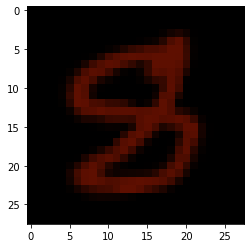

η: [  3.6124108 -10.65455  ]
g: [-0.02202768  0.03468722]
v: -1.1984946727752686
(r, g, b): [-0.8015054 -1.        -1.       ]


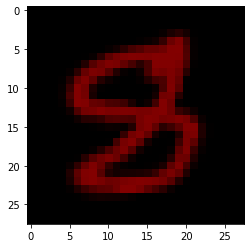

η: [11.036576   5.8347826]
g: [-0.01530593  0.0213275 ]
v: -1.2095643281936646
(r, g, b): [-0.7904357 -1.        -1.       ]


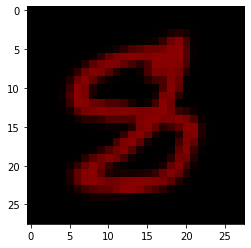

η: [-24.489529    2.7709632]
g: [-0.01162122  0.01524866]
v: -1.2146819829940796
(r, g, b): [-0.785318 -1.       -1.      ]


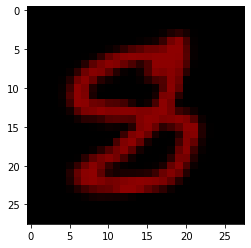

η: [-6.9094796  1.9275177]
g: [-0.00935101  0.01182157]
v: -1.217607855796814
(r, g, b): [-0.78239214 -1.         -1.        ]


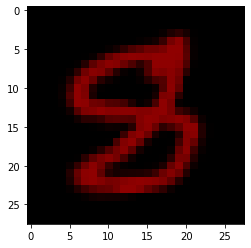

η: [-4.3023257  1.5129591]
g: [-0.00782151  0.00963429]
v: -1.2194970846176147
(r, g, b): [-0.7805029 -1.        -1.       ]


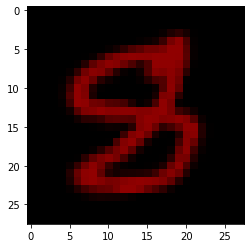

η: [-3.2295659  1.2579708]
g: [-0.00672323  0.00812149]
v: -1.2208162546157837
(r, g, b): [-0.77918375 -1.         -1.        ]


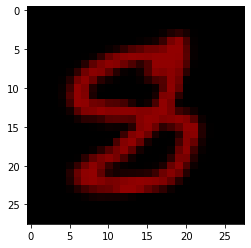

η: [-2.63446    1.0809726]
g: [-0.00589688  0.00701478]
v: -1.2217893600463867
(r, g, b): [-0.7782107 -1.        -1.       ]


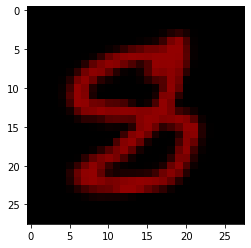

η: [-2.2508414  0.9484739]
g: [-0.00525272  0.00617084]
v: -1.2225366830825806
(r, g, b): [-0.7774633 -1.        -1.       ]


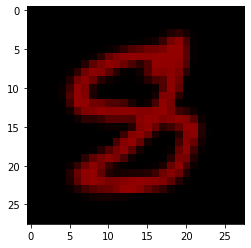

η: [-1.9799811  0.8440481]
g: [-0.00473639  0.00550652]
v: -1.2231285572052002
(r, g, b): [-0.7768715 -1.        -1.       ]


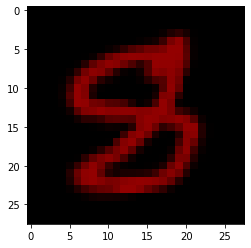

In [ ]:
def my_fn(η_, x, chan):
    new_x = hsv_transform_image(x, jnp.tanh(η_))
    means = jnp.mean(new_x, axis=(0, 1))
    mask = jnp.zeros_like(means)
    mask = mask.at[chan].set(1)
    return -jnp.sum(means * mask) + jnp.sum(means * (1 - mask)), new_x

grad_fn = jax.value_and_grad(my_fn, has_aux=True)

im = x
η_ = jnp.array([0.0, 0.1])
chan = 0

print(f'η: {jnp.tan(η_)}')
print(f'(r, g, b): {jnp.mean(im, axis=(0, 1))}')
plt.imshow(plotting_utils.rescale_for_imshow(im))
plt.show()


for i in range(101):
    (v, im_), g = grad_fn(η_, im, chan)
    η_ = η_ - 1e-0 * g
    if i % 10 == 0:
        print(f'η: {jnp.tan(η_)}')
        print(f'g: {g}')
        print(f'v: {v}')
        print(f'(r, g, b): {jnp.mean(im_, axis=(0, 1))}')
        plt.imshow(plotting_utils.rescale_for_imshow(im_))
        plt.show()

## Investigate Distributions

In [ ]:
def make_dist_plots(dist, rng, color='C0'):
    samples, _ = dist.sample_and_log_prob(seed=rng, sample_shape=(3000,))
    samples = samples / jnp.array(config.model.bounds)
    _, num_dims = samples.shape

    fig, axs = plt.subplots(1, num_dims, figsize=(20, 4), dpi=400, sharey=True)

    for i in range(num_dims):
        axs[i].hist(samples[:, i], bins=50, density=True, color=color, alpha=0.5)
        # plot a gaussian KDE over the histogram
        x = jnp.linspace(-1, 1, 1000)
        kde = gaussian_kde(samples[:, i])
        axs[i].plot(x, kde(x), color=color)

    fig.tight_layout()
    fig.show()


In [ ]:
η, η_, p_X_given_xhat_and_η, p_Η_given_xhat, q_Η_given_x = model.apply(
    {"params": final_state.params},
    x,
    rng,
    1.0,
    train=False
)


In [ ]:
final_state.params['σ_']

ShardedDeviceArray(0.38065583, dtype=float32)

In [ ]:
p_X_given_xhat_and_η.log_prob(x)

DeviceArray(-752.90405, dtype=float32)

-673.692


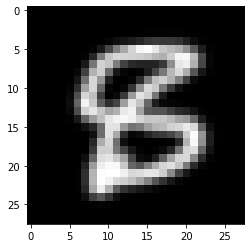

In [ ]:
x_rot = transform_image(x, jnp.array([0, 0, jnp.pi, 0, 0, 0, 0]))
plt.imshow(x_rot, cmap='gray')
print(p_X_given_xhat_and_η.log_prob(x_rot))

-786.0011


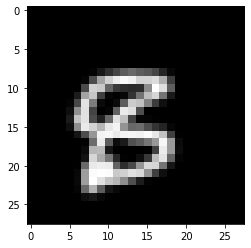

In [ ]:
x_trans = transform_image(x, jnp.array([0.25, 0.25, jnp.pi, 0.25, 0.25, 0, 0]))
plt.imshow(x_trans, cmap='gray')
print(p_X_given_xhat_and_η.log_prob(x_trans))

In [ ]:
η = approximate_mode(q_Η_given_x, 100, rng)
η

DeviceArray([-0.05048791, -0.07518937, -1.6429071 , -0.18842126,
             -0.2245992 , -0.01341782,  0.00817552], dtype=float32)

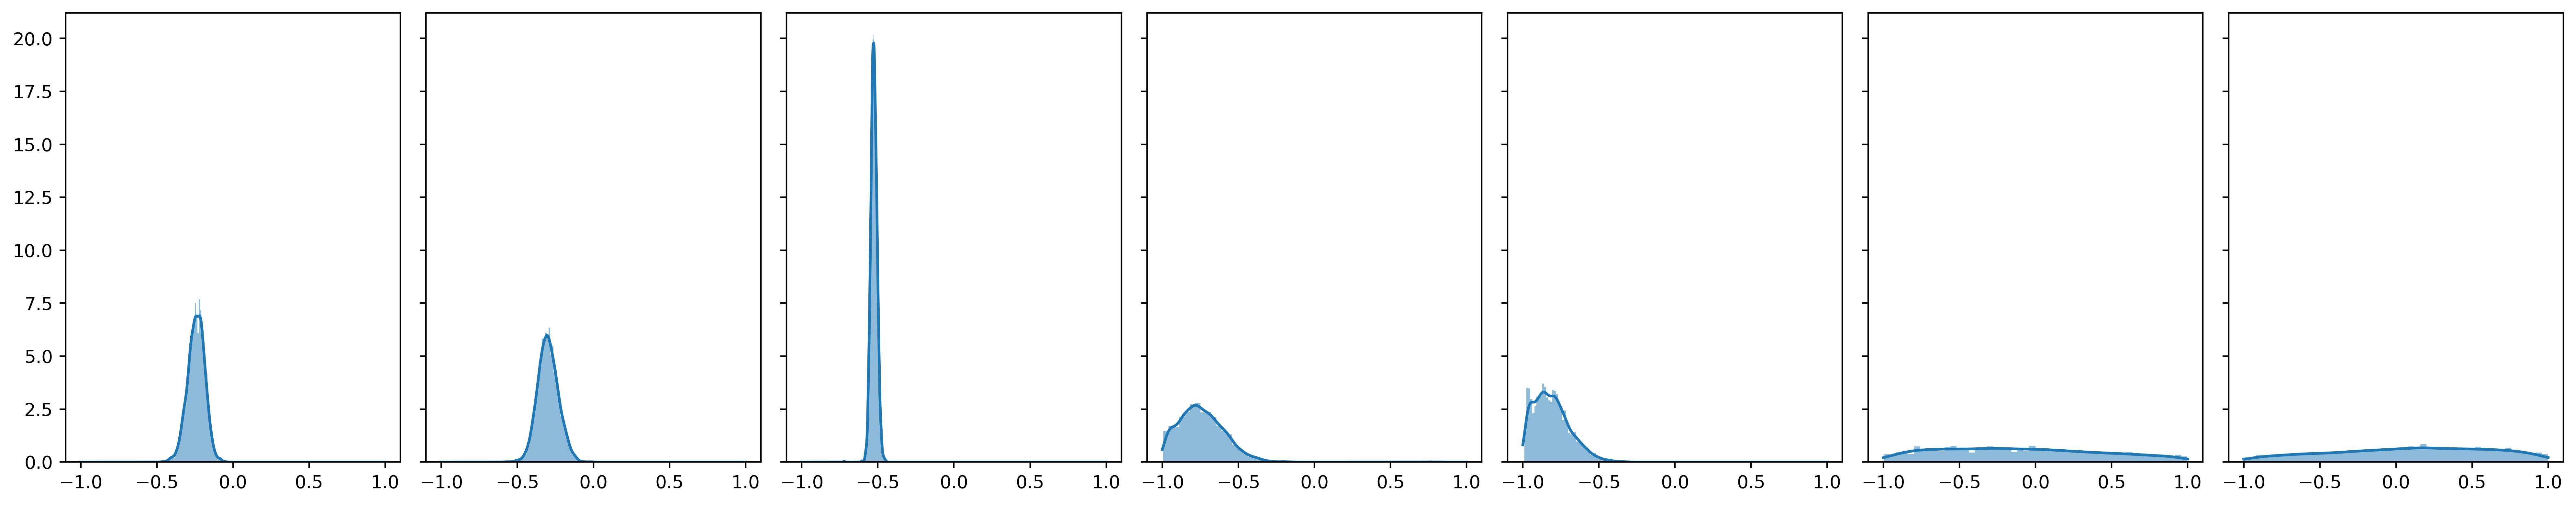

In [ ]:
make_dist_plots(q_Η_given_x, rng)

In [ ]:
q_Η_given_x.log_prob(η)

DeviceArray(18.315418, dtype=float32)

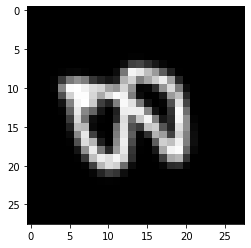

In [ ]:
x_hat = transform_image(x, -η)
plt.imshow(x_hat, cmap='gray')

In [ ]:
η2 = approximate_mode(p_Η_given_xhat, 1000, rng)
η2

DeviceArray([-0.11624698, -0.03274662, -1.7531292 , -0.24303898,
             -0.20750642,  0.02477482, -0.02615862], dtype=float32)

In [ ]:
p_Η_given_xhat.log_prob(η2)

DeviceArray(13.689987, dtype=float32)

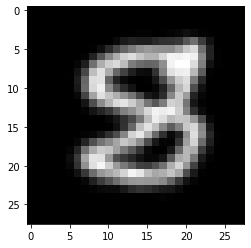

In [ ]:
x_rec = transform_image(x_hat, η2)
plt.imshow(x_rec, cmap='gray')